# Import library

In [ ]:
# utilities packages
import datetime

# data wrangling and transformation package
import numpy as np
import pandas as pd
import statsmodels.api as sm

# data visualization package
import matplotlib.pyplot as plt
import seaborn as sns

# time series modeling
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, month_plot
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.seasonal import seasonal_decompose # Import seasonal_decompose

# Install sktime and upgrade pip
!pip install --upgrade pip
# Uninstall scikit-learn and numpy to ensure compatibility
!pip uninstall scikit-learn numpy -y
# Reinstall scikit-learn, which will install a compatible version of numpy
!pip install scikit-learn==1.3.0 numpy --upgrade
!pip install sktime==0.25.0

# load sktime for time series forecasting
from sktime.utils.plotting import plot_series # from plotting
from sktime.forecasting.naive import NaiveForecaster # for naive forecasting
from sktime.forecasting.arima import AutoARIMA # for automated ARIMA forecasting
from sktime.forecasting.exp_smoothing import ExponentialSmoothing # for exponential smoothing forecasting
from sktime.forecasting.ets import AutoETS # for automated ETS forecasting
from sktime.forecasting.tbats import TBATS # for TBATS forecasting
from sktime.forecasting.fbprophet import Prophet # for Prophet forecasting
from sktime.forecasting.base import ForecastingHorizon # for creating forecast horizon
from sktime.forecasting.model_selection import (
    temporal_train_test_split,
    ExpandingWindowSplitter,
    SlidingWindowSplitter
) # for train-test split and cross validation
from sktime.performance_metrics.forecasting import (
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error
) # for evaluation metrics
from sktime.forecasting.model_evaluation import evaluate # for evaluating CV results

# Import prophet after installation
!pip install prophet
from prophet import Prophet


%matplotlib inline

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

Found existing installation: scikit-learn 1.3.0
Uninstalling scikit-learn-1.3.0:
  Successfully uninstalled scikit-learn-1.3.0
Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
  Using cached scikit_learn-1.3.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
  Using cached numpy-2.2.6-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
Using cached scikit_learn-1.3.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (10.9 MB)
Using cached numpy-2.2.6-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.8 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [scikit-learn]
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sktime 0.25.0 requires numpy<1.27,>=1.21, but you have numpy 2.2.6 which is incompatible.
pandas 2.1.4 requires numpy<

# Load dataset full

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/hadimaster65555/dataset_for_teaching/main/dataset/time_series_data/superstore_time_series_dataset/superstore_train.csv")
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


## Data Understanding

Metadata dari dataset yang akan dianalisis berdasarkan guidance:
* Row ID - Nomor urut.
* Order ID - ID yang dibuat ketika pesanan produk ditempatkan.
* Order Date - Tanggal pelanggan menempatkan pesanannya.
* Ship Date - Tanggal pesanan dikirim.
* Ship Mode - Moda pengiriman setiap pesanan.
* Customer ID - ID pelanggan.
* Customer Name - Nama pelanggan.
* Segment - Segmen pelanggan.
* Country - Negara (fokus pada data toko AS).
* City - Kota tempat transaksi terjadi.
* State - Negara bagian tempat transaksi terjadi.
* Postal Code - Kode pos.
* Region - Wilayah tempat transaksi terjadi.
* Product ID - ID setiap produk.
* Category - Kategori produk.
* Sub-Category - Sub-kategori produk.
* Product Name - Nama produk.
* Sales - Harga jual produk.
* Quantity - Jumlah produk yang terjual.
* Discount - Diskon pada setiap produk.
* Profit - Keuntungan yang diperoleh dari penjualan.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         8000 non-null   int64  
 1   Order ID       8000 non-null   object 
 2   Order Date     8000 non-null   object 
 3   Ship Date      8000 non-null   object 
 4   Ship Mode      8000 non-null   object 
 5   Customer ID    8000 non-null   object 
 6   Customer Name  8000 non-null   object 
 7   Segment        8000 non-null   object 
 8   Country        8000 non-null   object 
 9   City           8000 non-null   object 
 10  State          8000 non-null   object 
 11  Postal Code    8000 non-null   int64  
 12  Region         8000 non-null   object 
 13  Product ID     8000 non-null   object 
 14  Category       8000 non-null   object 
 15  Sub-Category   8000 non-null   object 
 16  Product Name   8000 non-null   object 
 17  Sales          8000 non-null   float64
 18  Quantity

In [ ]:
#drop kolum Row ID
df = df.drop(columns=['Row ID'])

In [ ]:
# Change data type
df["Order Date"] = pd.to_datetime(df["Order Date"])
df["Ship Date"] = pd.to_datetime(df["Ship Date"])

In [ ]:
# Change data type
df["Order Date"] = pd.to_datetime(df["Order Date"], format="%Y-%m-%d")
df["Ship Date"] = pd.to_datetime(df["Ship Date"], format="%Y-%m-%d")

## Preprocessing

### Duplicate

In [ ]:
#cek duplicate data
len(df.drop_duplicates()) / len(df)
#jika output dari code di cell ini tidak bernilai 1 maka terdapat duplikat

0.999875

In [ ]:
# Handling Drop Duplicated
df = df.drop_duplicates()

In [ ]:
#cek duplicate data
len(df.drop_duplicates()) / len(df)
#jika output dari code di cell ini tidak bernilai 1 maka terdapat duplikat

1.0

### Missing value

In [ ]:
row_n,col_n=df.shape
row_n,col_n=df.shape
df_desc=df.isna().sum(axis=0).reset_index()
df_desc.columns=['Variable','Missing_values']
df_desc['Filling_Values (%)']=(row_n-df_desc['Missing_values'])*100/row_n
df_desc['Filling_Values (%)'] = df_desc['Filling_Values (%)'].round(2)
df_desc

,Variable,Missing_values,Filling_Values (%)
0,Order ID,0,100.0
1,Order Date,0,100.0
2,Ship Date,0,100.0
3,Ship Mode,0,100.0
4,Customer ID,0,100.0
5,Customer Name,0,100.0
6,Segment,0,100.0
7,Country,0,100.0
8,City,0,100.0
9,State,0,100.0


In [ ]:
#cek missing value satu-satu
for column in df.columns:
    print(f"============= {column} =================")
    display(df[column].value_counts())
    print()

Output hidden; open in https://colab.research.google.com to view.

## EDA

**1. Hitunglah total revenue, jumlah order, dan jumlah barang yang terjual sepanjang tahun 2017. Selain itu, hitung rata-rata jumlah barang yang dibeli per transaksi dan rata-rata spending per transaksi.**

In [ ]:
#make year columns
#berdasarkan metadata sales = harga produck, maka kita perlu mencari revenue per baris
df['revenue']=df['Sales']*df['Quantity']*(1-df['Discount'])
df['year']=df['Order Date'].dt.year

In [ ]:
# Filter data only show 2017
df_2017 = df[df['year']==2017]
df_2017.head()

,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,revenue,year
12,CA-2017-114412,2017-04-15,2017-04-20,Standard Class,AA-10480,Andrew Allen,Consumer,United States,Concord,North Carolina,28027,South,OFF-PA-10002365,Office Supplies,Paper,Xerox 1967,15.552,3,0.2,5.4432,37.3248,2017
23,US-2017-156909,2017-07-16,2017-07-18,Second Class,SF-20065,Sandra Flanagan,Consumer,United States,Philadelphia,Pennsylvania,19140,East,FUR-CH-10002774,Furniture,Chairs,"Global Deluxe Stacking Chair, Gray",71.372,2,0.3,-1.0196,99.9208,2017
34,CA-2017-107727,2017-10-19,2017-10-23,Second Class,MA-17560,Matt Abelman,Home Office,United States,Houston,Texas,77095,Central,OFF-PA-10000249,Office Supplies,Paper,Easy-staple paper,29.472,3,0.2,9.9468,70.7328,2017
41,CA-2017-120999,2017-09-10,2017-09-15,Standard Class,LC-16930,Linda Cazamias,Corporate,United States,Naperville,Illinois,60540,Central,TEC-PH-10004093,Technology,Phones,Panasonic Kx-TS550,147.168,4,0.2,16.5564,470.9376,2017
43,CA-2017-139619,2017-09-19,2017-09-23,Standard Class,ES-14080,Erin Smith,Corporate,United States,Melbourne,Florida,32935,South,OFF-ST-10003282,Office Supplies,Storage,"Advantus 10-Drawer Portable Organizer, Chrome ...",95.616,2,0.2,9.5616,152.9856,2017


In [ ]:
# Menghitung metrik yang diminta
total_revenue = df_2017['revenue'].sum() # Hitung total revenue sepanjang 2017
total_orders = df_2017['Order ID'].nunique() # Hitung jumlah order unik sepanjang 2017
total_quantity = df_2017['Quantity'].sum() # Hitung total barang terjual sepanjang 2017
avg_quantity_per_order = df_2017.groupby('Order ID')['Quantity'].sum().mean() # Hitung rata-rata barang per transaksi (order)
avg_spending_per_order = df_2017.groupby('Order ID')['revenue'].sum().mean() # Hitung rata-rata spending per transaksi (order)

# Buat dataframe ringkasan hasil
summary_df = pd.DataFrame({
    'Metrik': [
        'Total Revenue 2017',
        'Jumlah Order 2017',
        'Jumlah Barang Terjual 2017',
        'Rata-rata Barang per Transaksi',
        'Rata-rata Spending per Transaksi'
    ],
    'Nilai': [
        f"${total_revenue:,.2f}",
        total_orders,
        total_quantity,
        f"{avg_quantity_per_order:.2f} unit/order",
        f"${avg_spending_per_order:,.2f}"
    ]
})

print(summary_df)

                             Metrik            Nilai
0                Total Revenue 2017    $2,489,712.05
1                 Jumlah Order 2017             1341
2        Jumlah Barang Terjual 2017            10085
3    Rata-rata Barang per Transaksi  7.52 unit/order
4  Rata-rata Spending per Transaksi        $1,856.61


Dari data transaksi tahun 2017, total revenue yang diperoleh mencapai sekitar 2,489,712 dengan jumlah order sebanyak 1,341 transaksi. Total barang yang terjual sebanyak 10,085 unit, dengan rata-rata pembelian per transaksi sekitar 7,52 unit. Rata-rata pengeluaran per transaksi sebesar 1,856,61. dari data tersebut dapat dilihat bahwa pelanggan cenderung melakukan pembelian dalam jumlah cukup banyak per transaksi, dan nilai pengeluaran per transaksi relatif tinggi, menunjukkan potensi loyalitas pelanggan dan kesempatan untuk meningkatkan pendapatan melalui strategi penjualan bundling atau promosi pembelian dalam jumlah besar.

**2. Hitunglah jumlah order dan GMV yang diperoleh dengan rentang waktu berikut:**
   * Harian
   * Mingguan
   * Bulanan

**Catatan:** GMV dihitung berdasarkan total spending yang dilakukan customer dengan memperhitungkan semua biaya dan diskon yang dibayarkan customer.

In [ ]:
# Days column
df["days"] = df['Order Date'].dt.day

# Weeks column
df["weekdays"] = [x.strftime('%A') for x in df["Order Date"]]

# Months column
df["months"] = df["Order Date"].dt.month

**Jumlah Order** 🔽

In [ ]:
# Daily order
order_daily = df.groupby("days",as_index=False)["Order ID"].size()

# Weekly order
weekly = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
order_weekly = df.groupby("weekdays",as_index=False)["Order ID"].size()

# Monthly order
order_monthly = df.groupby("months",as_index=False)["Order ID"].size()

<ipython-input-17-78e5d1eaee51>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=order_weekly,x="weekdays",y="size", order = weekly, palette = "Set1", ax=ax2).set_title("Total Orders by Weekday")


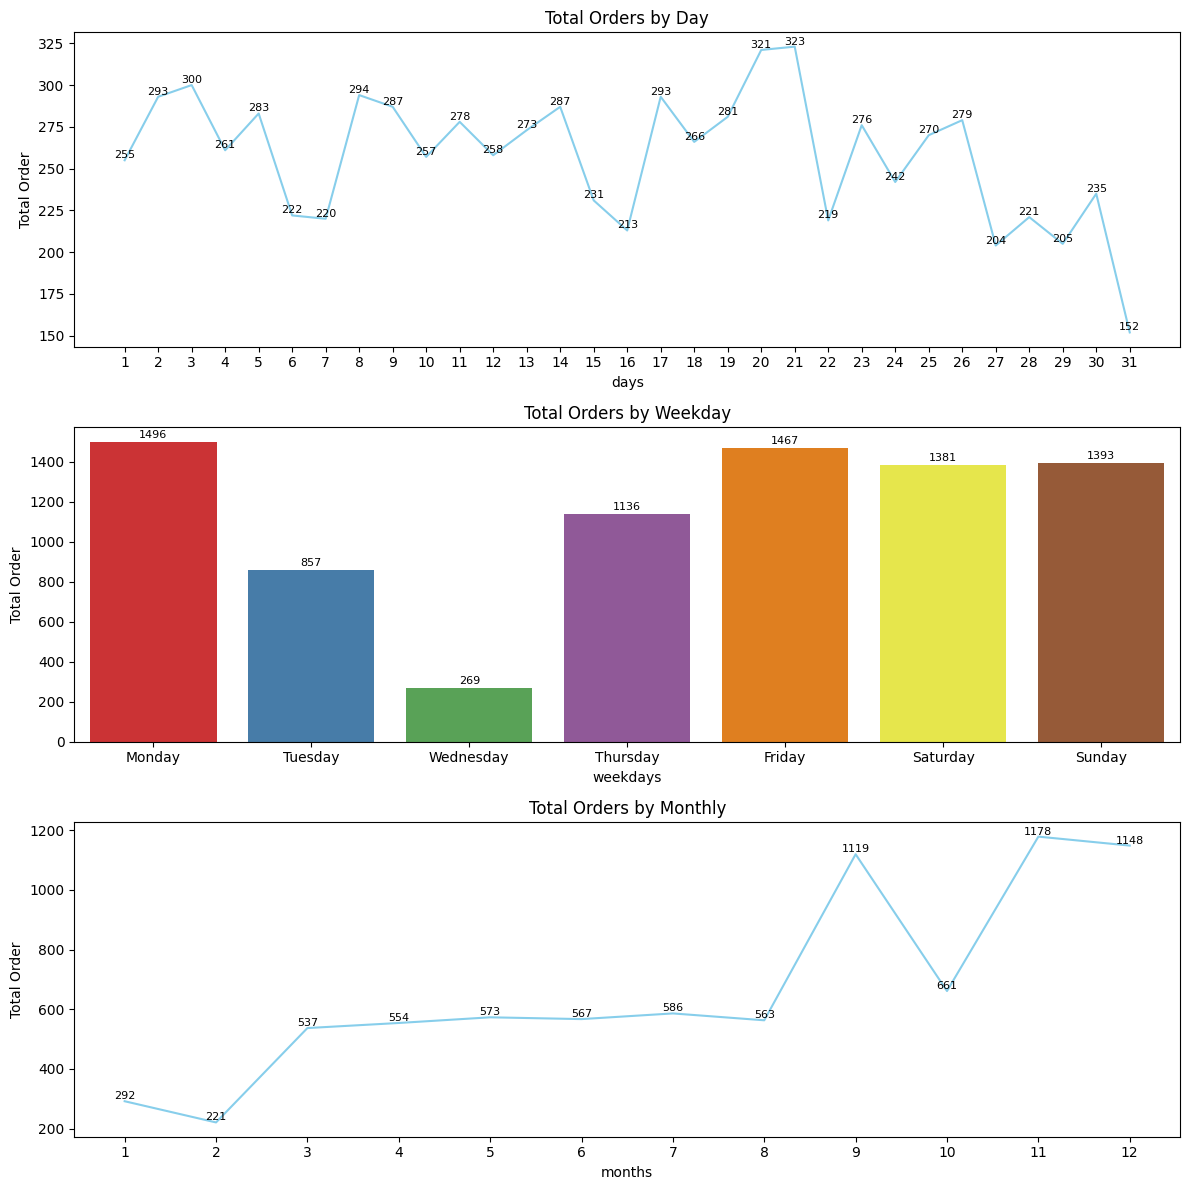

In [ ]:
# Visualization
plt.figure(figsize=(12,12))

# Create the first subplot and capture the Axes object
ax1 = plt.subplot(311)
sns.lineplot(data=order_daily,x="days",y="size", ax=ax1, color = "skyblue").set_title("Total Orders by Day")
plt.xticks([i for i in np.arange(1,32)])
plt.ylabel("Total Order")
#  Add a number label to each point
for x, y in zip(order_daily['days'], order_daily['size']):
    ax1.text(x, y, f'{y:.0f}', ha='center', va='bottom', fontsize=8)

# Create the second subplot and capture the Axes object
ax2 = plt.subplot(312)
sns.barplot(data=order_weekly,x="weekdays",y="size", order = weekly, palette = "Set1", ax=ax2).set_title("Total Orders by Weekday")
plt.ylabel("Total Order")
#  Add a number label to each bar
for p in ax2.patches:
    height = p.get_height()
    ax2.text(p.get_x() + p.get_width()/2., height + 10, f'{int(height)}', ha='center', va='bottom', fontsize=8)

# Create the third subplot and capture the Axes object
ax3 = plt.subplot(313)
sns.lineplot(data=order_monthly,x="months",y="size", ax=ax3, color="skyblue").set_title("Total Orders by Monthly")
plt.xticks([i for i in np.arange(1,13)])
plt.ylabel("Total Order")
# Add a number label to each point
for x, y in zip(order_monthly['months'], order_monthly['size']):
    ax3.text(x, y, f'{y:.0f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

Jumlah order harian menunjukkan fluktuasi dengan puncak tertinggi pada hari ke-20 dan ke-21. Secara mingguan, hari Jumat dan Senin memiliki total order terbanyak, sementara hari Rabu paling rendah. Secara bulanan, jumlah order meningkat signifikan pada bulan September dan November, menandakan adanya peningkatan aktivitas transaksi pada periode tersebut.

**Jumlah GMV** 🔽

In [ ]:
# Create GMV column
# karena GMV menghitung->GMV = (Sales × Qty × (1 - Discount)) + Biaya Lainnya, dan disini tidak dijelaskan biasya lainnya , maka GMV = revenue
df['GMV'] = df['Sales']*df['Quantity'] * (1 - df['Discount'])

In [ ]:
df.head(2)

,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,revenue,year,days,weekdays,months,GMV
0,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.96,2,0.0,41.9136,523.92,2016,8,Tuesday,11,523.92
1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.94,3,0.0,219.5820,2195.82,2016,8,Tuesday,11,2195.82


In [ ]:
# Daily GMV
gmv_daily = df.groupby("days",as_index=False)["GMV"].size()

# Weekly GMV
gmv_weekly = df.groupby("weekdays",as_index=False)["GMV"].size()

# Monthly GMV
gmv_monthly = df.groupby("months",as_index=False)["GMV"].size()

<ipython-input-21-ade256b2ed0d>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=gmv_weekly,x="weekdays",y="size", order = weekly, palette = "Set1", ax=ax2).set_title("Total GMV by Weekday")


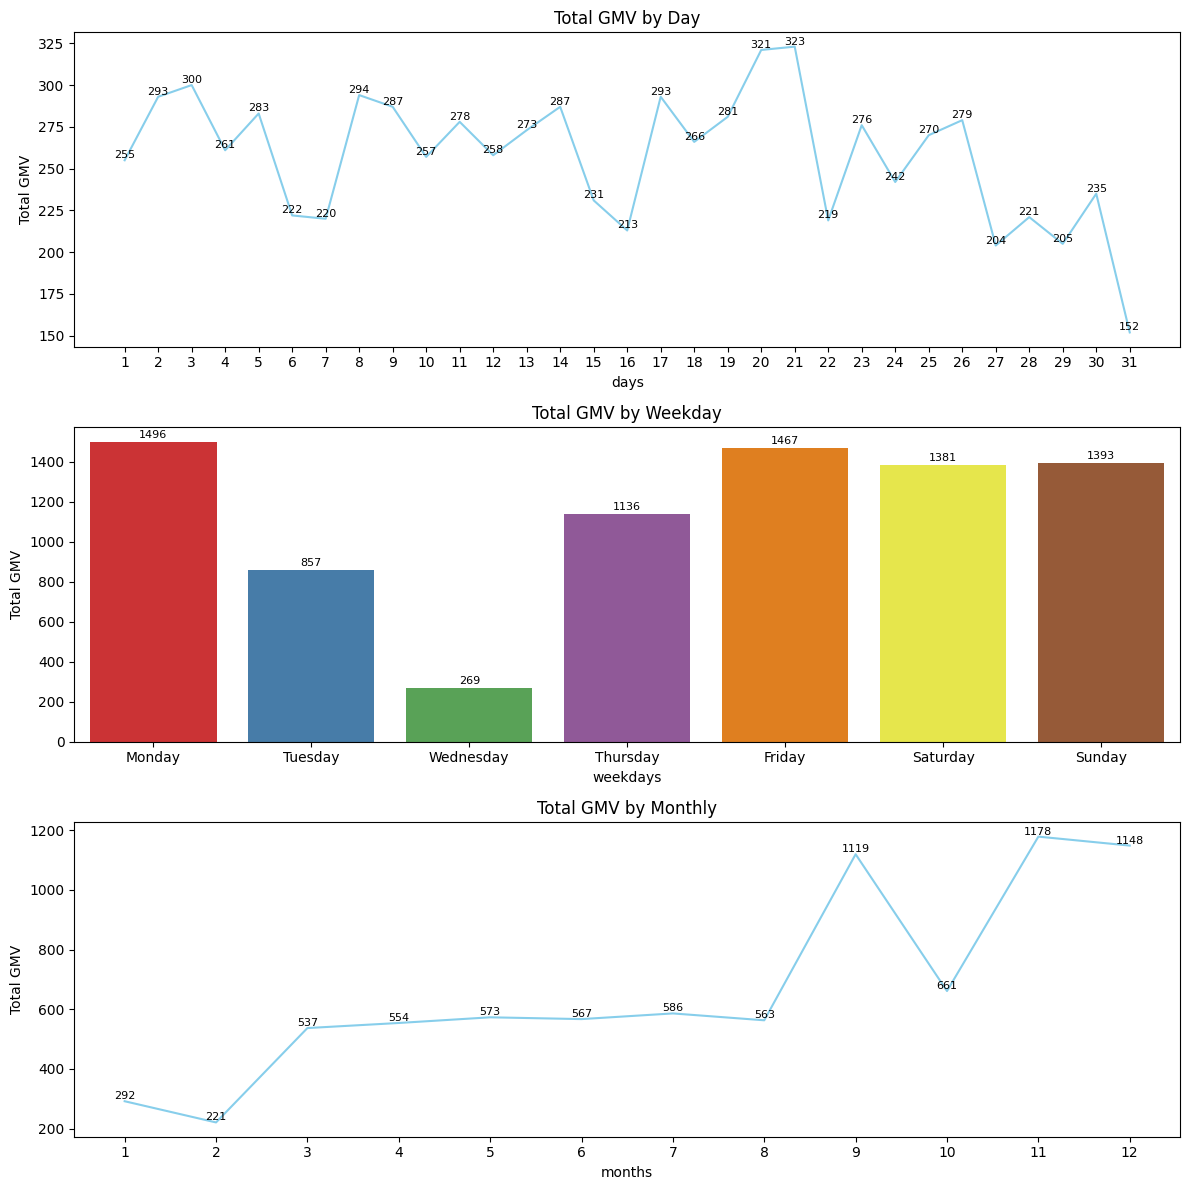

In [ ]:
# Visualization
plt.figure(figsize=(12,12))

# Create the first subplot and capture the Axes object
ax1 = plt.subplot(311)
sns.lineplot(data=gmv_daily,x="days",y="size", ax=ax1, color = "skyblue").set_title("Total GMV by Day")
plt.xticks([i for i in np.arange(1,32)])
plt.ylabel("Total GMV")
#  Add a number label to each point
for x, y in zip(gmv_daily['days'], gmv_daily['size']):
    ax1.text(x, y, f'{y:.0f}', ha='center', va='bottom', fontsize=8)

# Create the second subplot and capture the Axes object
ax2 = plt.subplot(312)
sns.barplot(data=gmv_weekly,x="weekdays",y="size", order = weekly, palette = "Set1", ax=ax2).set_title("Total GMV by Weekday")
plt.ylabel("Total GMV")
#  Add a number label to each bar
for p in ax2.patches:
    height = p.get_height()
    ax2.text(p.get_x() + p.get_width()/2., height + 10, f'{int(height)}', ha='center', va='bottom', fontsize=8)

# Create the third subplot and capture the Axes object
ax3 = plt.subplot(313)
sns.lineplot(data=gmv_monthly,x="months",y="size", ax=ax3, color="skyblue").set_title("Total GMV by Monthly")
plt.xticks([i for i in np.arange(1,13)])
plt.ylabel("Total GMV")
# Add a number label to each point
for x, y in zip(gmv_monthly['months'], gmv_monthly['size']):
    ax3.text(x, y, f'{y:.0f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

Total GMV per hari mengikuti pola yang mirip dengan jumlah order harian, dengan nilai tertinggi pada hari ke-20 dan ke-21. GMV mingguan juga paling tinggi pada hari Jumat dan Senin, sejalan dengan jumlah order. Pada tingkat bulanan, GMV mengalami lonjakan signifikan pada bulan September dan November, mencerminkan peningkatan total nilai transaksi yang konsisten dengan tren order.

**3. Identifikasi _top 10 produk_ yang membawa revenue terbesar dalam 3 bulan terakhir dan produk apa saja yang bisa di-bundling berdasarkan hasil analisis.**

**Top 10 Product by Highest Revenue in the last 3 months** 🔽

In [ ]:
# Tentukan tanggal akhir (bisa sekarang atau maksimum tanggal di data)
max_date = df_2017['Order Date'].max()

# Hitung tanggal awal 3 bulan sebelum max_date
start_date = max_date - pd.DateOffset(months=3)

# Filter data untuk 3 bulan terakhir
df_last_3_months = df[(df['Order Date'] >= start_date) & (df['Order Date'] <= max_date)]
df_last_3_months.head()

,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,revenue,year,days,weekdays,months,GMV
34,CA-2017-107727,2017-10-19,2017-10-23,Second Class,MA-17560,Matt Abelman,Home Office,United States,Houston,Texas,77095,Central,OFF-PA-10000249,Office Supplies,Paper,Easy-staple paper,29.472,3,0.2,9.9468,70.7328,2017,19,Thursday,10,70.7328
75,US-2017-118038,2017-12-09,2017-12-11,First Class,KB-16600,Ken Brennan,Corporate,United States,Houston,Texas,77041,Central,OFF-BI-10004182,Office Supplies,Binders,Economy Binders,1.248,3,0.8,-1.9344,0.7488,2017,9,Saturday,12,0.7488
76,US-2017-118038,2017-12-09,2017-12-11,First Class,KB-16600,Ken Brennan,Corporate,United States,Houston,Texas,77041,Central,FUR-FU-10000260,Furniture,Furnishings,"6"" Cubicle Wall Clock, Black",9.708,3,0.6,-5.8248,11.6496,2017,9,Saturday,12,11.6496
77,US-2017-118038,2017-12-09,2017-12-11,First Class,KB-16600,Ken Brennan,Corporate,United States,Houston,Texas,77041,Central,OFF-ST-10000615,Office Supplies,Storage,"SimpliFile Personal File, Black Granite, 15w x...",27.240,3,0.2,2.7240,65.3760,2017,9,Saturday,12,65.3760
84,US-2017-119662,2017-11-13,2017-11-16,First Class,CS-12400,Christopher Schild,Home Office,United States,Chicago,Illinois,60623,Central,OFF-ST-10003656,Office Supplies,Storage,Safco Industrial Wire Shelving,230.376,3,0.2,-48.9549,552.9024,2017,13,Monday,11,552.9024


In [ ]:
## 2. Hitung total revenue per produk dalam 3 bulan terakhir
product_revenue = df_last_3_months.groupby(['Product ID', 'Product Name', 'Category', 'Sub-Category'])\
                             .agg({'Sales': 'sum', 'Quantity': 'sum', 'revenue' : 'sum', 'Order ID': 'nunique'})\
                             .rename(columns={'revenue': 'Total Revenue', 'Order ID': 'Order Count'})\
                             .sort_values('Total Revenue', ascending=False)

# Ambil top 10 produk
top10_products = product_revenue.head(10).reset_index()
top10_products

,Product ID,Product Name,Category,Sub-Category,Sales,Quantity,Total Revenue,Order Count
0,TEC-CO-10004722,Canon imageCLASS 2200 Advanced Copier,Technology,Copiers,21699.938,7,67339.8076,2
1,OFF-AP-10002684,"Acco 7-Outlet Masterpiece Power Center, Wihtou...",Office Supplies,Appliances,2091.176,18,25074.6592,2
2,FUR-TA-10003954,Hon 94000 Series Round Tables,Furniture,Tables,2665.620,9,23990.5800,1
3,OFF-ST-10003208,Adjustable Depth Letter/Legal Cart,Office Supplies,Storage,4028.412,23,22726.0504,4
4,OFF-AP-10000891,Kensington 7 Outlet MasterPiece HOMEOFFICE Pow...,Office Supplies,Appliances,1704.560,13,22159.2800,1
5,TEC-PH-10002834,Google Nexus 5,Technology,Phones,1979.890,11,21778.7900,1
6,TEC-MA-10001047,"3D Systems Cube Printer, 2nd Generation, Magenta",Technology,Machines,5199.960,4,20799.8400,1
7,TEC-AC-10004145,Logitech diNovo Edge Keyboard,Technology,Accessories,2249.910,9,20249.1900,1
8,OFF-ST-10001526,Iceberg Mobile Mega Data/Printer Cart,Office Supplies,Storage,1925.280,16,19252.8000,2
9,TEC-PH-10001494,Polycom CX600 IP Phone VoIP phone,Technology,Phones,2399.600,8,19196.8000,1


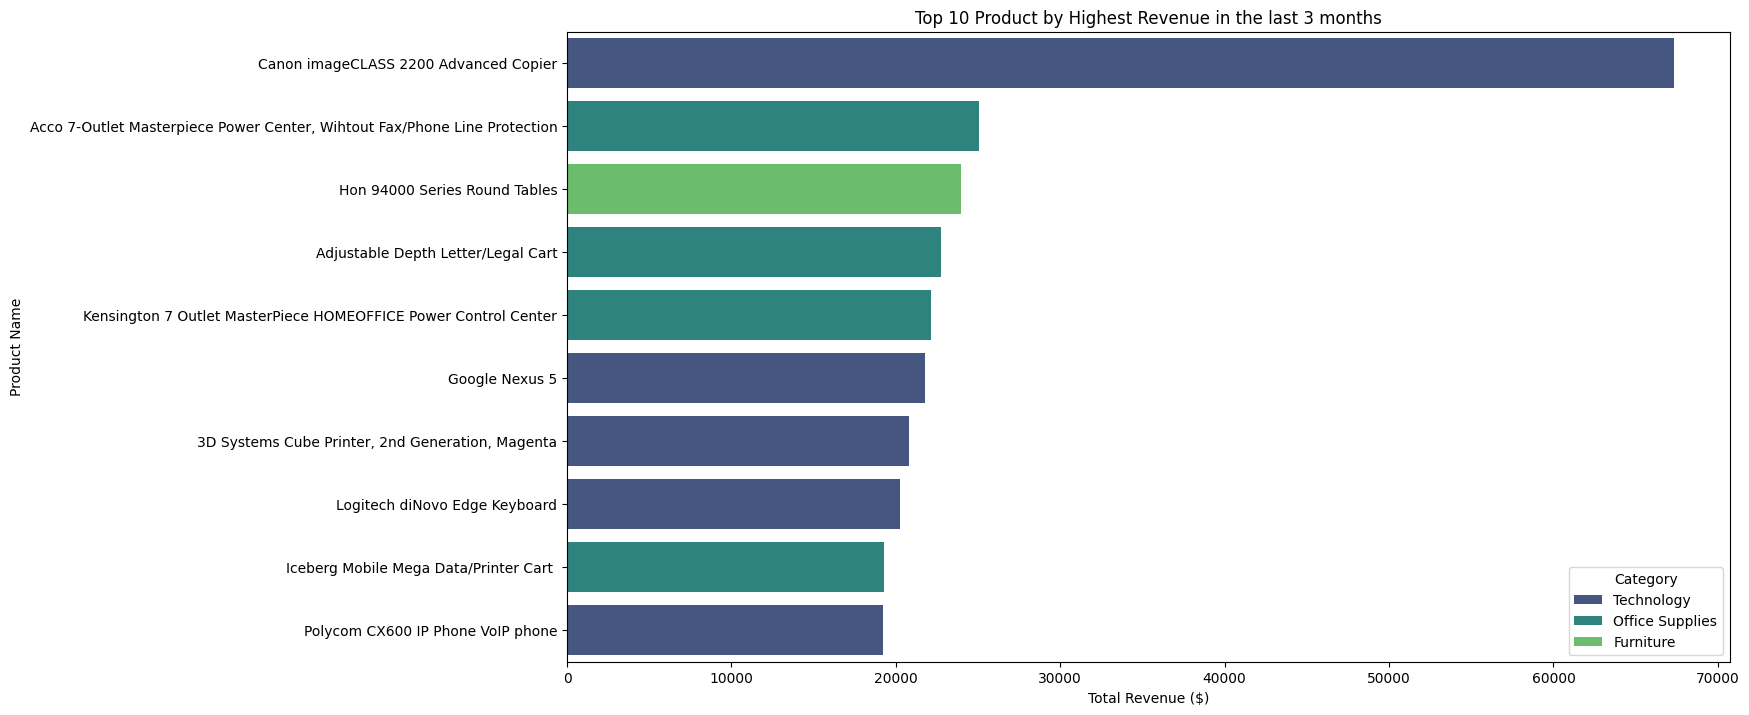

In [ ]:
## 3. Visualisasi Top 10 Produk
plt.figure(figsize=(15, 18)) # Added figure size for better readability
plt.subplot(2, 1, 1)
sns.barplot(data=top10_products, x='Total Revenue', y='Product Name', hue='Category',
            palette='viridis', dodge=False)
plt.title('Top 10 Product by Highest Revenue in the last 3 months', fontsize=12)
plt.xlabel('Total Revenue ($)')
plt.ylabel('Product Name')
plt.ticklabel_format(style='plain', axis='x')

Produk Canon imageCLASS 2200 Advanced Copier menempati posisi teratas dengan total revenue hampir $67,340, jauh mengungguli produk lainnya. Beberapa produk dari kategori Technology mendominasi daftar, menunjukkan tingginya permintaan untuk perangkat teknologi. Produk-produk dari kategori Office Supplies dan Furniture juga termasuk dalam daftar, menunjukkan variasi produk yang diminati pelanggan. Tim marketing dapat mempertimbangkan bundling produk-produk ini untuk memaksimalkan penjualan dan menarik pelanggan dengan kombinasi produk populer dari beberapa kategori.

**Analyst Bundling Product** 🔽

<ipython-input-89-237559e2e033>:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bundling_df, x='Frequency', y='Product Pair String', palette='rocket')
<ipython-input-89-237559e2e033>:36: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


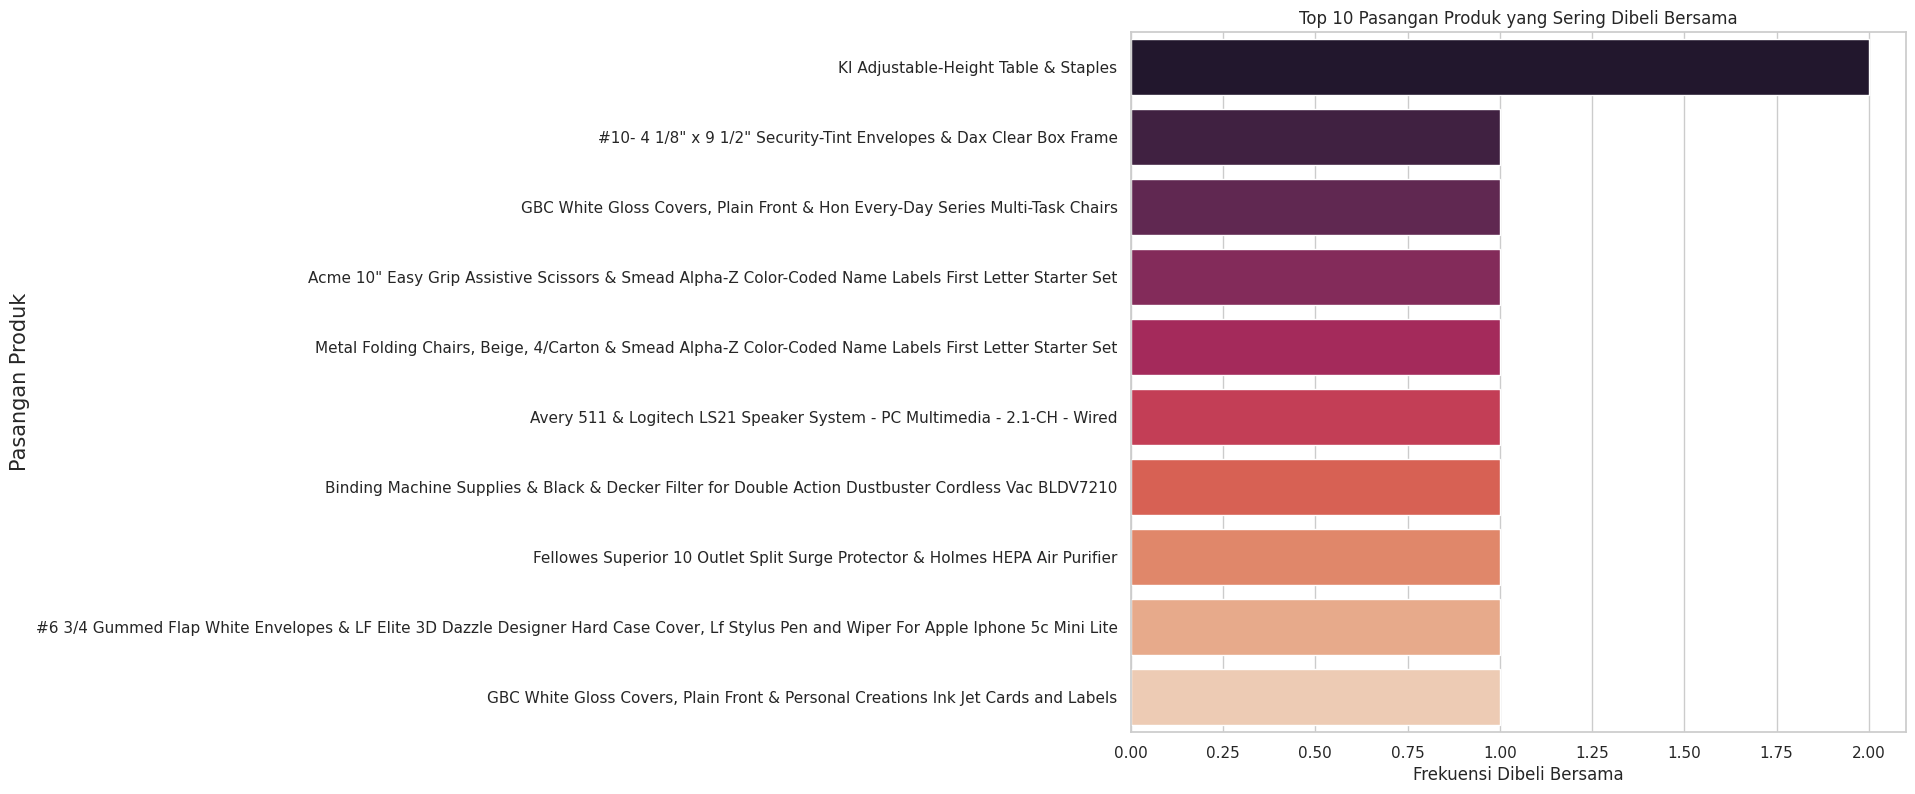

In [ ]:
## 4. Analisis Produk Potensial untuk Bundling
# Identifikasi produk yang sering dibeli bersama dalam satu transaksi
# Hitung frekuensi kemunculan pasangan produk dalam order yang sama
from itertools import combinations
from collections import defaultdict

# Dictionary untuk menyimpan frekuensi pasangan produk
product_pairs = defaultdict(int)

# Analisis per order
# Menggunakan df_last_3_months yang berisi data 3 bulan terakhir
for order_id, group in df_last_3_months.groupby('Order ID'):
    products = group['Product Name'].unique()
    # Generate semua kombinasi pasangan produk dalam order
    for pair in combinations(products, 2):
        # Store the pair as a tuple for counting
        product_pairs[tuple(sorted(pair))] += 1

# Konversi ke dataframe dan urutkan
bundling_df = pd.DataFrame(list(product_pairs.items()), columns=['Product Pair', 'Frequency'])
bundling_df = bundling_df.sort_values('Frequency', ascending=False).head(10)

# Convert the tuple of product names into a single string for plotting
bundling_df['Product Pair String'] = bundling_df['Product Pair'].apply(lambda x: f"{x[0]} & {x[1]}")


## 5. Visualisasi Produk Potensial Bundling
plt.figure(figsize=(10, 20)) # Added figure size for better readability
plt.subplot(2, 1, 2)
# Use the new string column for the y-axis
sns.barplot(data=bundling_df, x='Frequency', y='Product Pair String', palette='rocket')
plt.title('Top 10 Pasangan Produk yang Sering Dibeli Bersama', fontsize=12)
plt.xlabel('Frekuensi Dibeli Bersama')
plt.ylabel('Pasangan Produk')

plt.tight_layout()
plt.show()

Beberapa produk, seperti KI Adjustable-Height Table & Staples, #10- 4 1/8" x 9 1/2" Security-Tint Envelopes & Dax Clear Box Frame, GBC White Gloss Covers & Hon Every-Day Series Multi-Task Chairs, serta Acme 10" Easy Grip Assistive Scissors & Smead Alpha-Z Color-Coded Name Labels First Letter Starter Set, sering dibeli bersama oleh pelanggan. Hal ini menunjukkan bahwa produk-produk tersebut saling melengkapi dan biasanya dibutuhkan secara bersamaan dalam aktivitas kantor. Tim marketing bisa membuat paket bundling dari produk-produk yang sering dibeli bersama ini. Dengan cara ini, pelanggan lebih mudah mendapatkan kebutuhan mereka sekaligus, sementara perusahaan bisa meningkatkan penjualan dan memperkuat hubungan dengan pelanggan.


**4. Identifikasi top 5 kota yang memiliki order terbanyak dan 5 kota yang memiliki total dan rata-rata spending terbesar.**

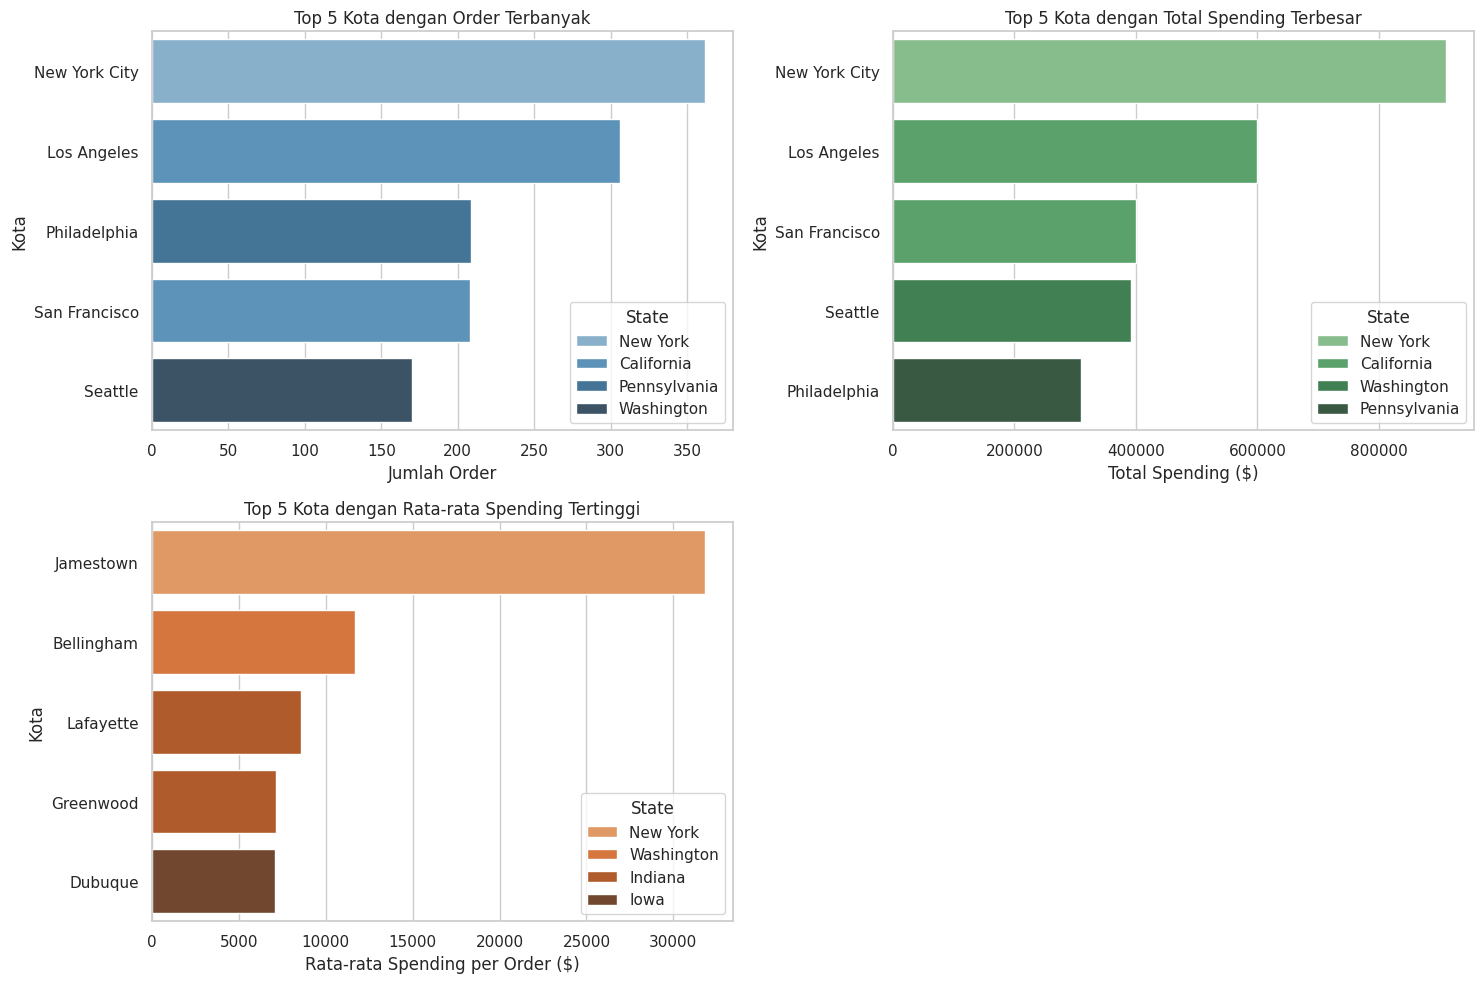

In [ ]:
# Set style visualisasi
sns.set(style="whitegrid")
plt.figure(figsize=(15, 10))

## Top 5 Kota dengan Order Terbanyak
city_orders = df.groupby(['City', 'State'])['Order ID'].nunique().reset_index()
city_orders.columns = ['City', 'State', 'Total Orders']
top5_order_cities = city_orders.sort_values('Total Orders', ascending=False).head(5)

## Top 5 Kota dengan Total Spending Terbesar dan Rata-rata Spending Tertinggi
city_spending = df.groupby(['City', 'State'])['revenue'].agg(['sum', 'mean']).reset_index()
city_spending.columns = ['City', 'State', 'Total Spending', 'Average Spending']
top5_total_spending = city_spending.sort_values('Total Spending', ascending=False).head(5)
top5_avg_spending = city_spending[city_spending['Total Spending'] > 0].sort_values('Average Spending', ascending=False).head(5)

## 3. Visualisasi Data
# Plot 1: Top 5 Kota dengan Order Terbanyak
plt.subplot(2, 2, 1)
sns.barplot(data=top5_order_cities, x='Total Orders', y='City', hue='State', palette='Blues_d')
plt.title('Top 5 Kota dengan Order Terbanyak', fontsize=12)
plt.xlabel('Jumlah Order')
plt.ylabel('Kota')

# Plot 2: Top 5 Kota dengan Total Spending Terbesar
plt.subplot(2, 2, 2)
sns.barplot(data=top5_total_spending, x='Total Spending', y='City', hue='State', palette='Greens_d')
plt.title('Top 5 Kota dengan Total Spending Terbesar', fontsize=12)
plt.xlabel('Total Spending ($)')
plt.ylabel('Kota')
plt.ticklabel_format(style='plain', axis='x')

# Plot 3: Top 5 Kota dengan Rata-rata Spending Tertinggi
plt.subplot(2, 2, 3)
sns.barplot(data=top5_avg_spending, x='Average Spending', y='City', hue='State', palette='Oranges_d')
plt.title('Top 5 Kota dengan Rata-rata Spending Tertinggi', fontsize=12)
plt.xlabel('Rata-rata Spending per Order ($)')
plt.ylabel('Kota')

plt.tight_layout()
plt.show()

Top 5 kota dengan jumlah order terbanyak didominasi oleh kota-kota besar seperti New York City dan Los Angeles, menunjukkan konsentrasi aktivitas transaksi yang tinggi di pusat-pusat bisnis utama. Sementara itu, total spending terbesar juga dimimpin oleh kota-kota besar tersebut, namun San Francisco dan Seattle menunjukkan nilai transaksi yang signifikan meskipun ordernya tidak sebanyak kota lain. Menariknya, rata-rata spending per order tertinggi justru ditemukan di kota-kota yang tidak masuk dalam daftar top order, seperti Jamestown dan Bellingham, menandakan bahwa pelanggan di kota-kota tersebut melakukan pembelian dengan nilai yang jauh lebih besar per transaksi. Hal ini memberikan insight bahwa strategi pemasaran sebaiknya tidak hanya fokus pada volume order, tetapi juga memperhatikan nilai transaksi rata-rata untuk mengoptimalkan potensi pendapatan di berbagai wilayah.

# Visits Dataset

In [ ]:
## 1. Persiapan Data
# Hitung visit harian (karena tidak dijelaskan di metadanya maka asumsikan 1 customer dihitung 1 kali per hari, walaupun dia melakukan beberapa transaksi)
daily_visits = df.groupby(df['Order Date'].dt.date)['Customer ID'].nunique().reset_index()
daily_visits.columns = ['date', 'visits']
daily_visits['date'] = pd.to_datetime(daily_visits['date'])

daily_visits.head(10)

,date,visits
0,2014-01-03,1
1,2014-01-04,1
2,2014-01-05,1
3,2014-01-06,3
4,2014-01-07,1
5,2014-01-09,1
6,2014-01-10,1
7,2014-01-11,1
8,2014-01-13,3
9,2014-01-14,1


## Preprocessing data

In [ ]:
# Cek apakah data sudah terurut berdasarkan tanggal
is_sorted = daily_visits['date'].is_monotonic_increasing
print(f"Data sudah terurut berdasarkan tanggal: {is_sorted}")

Data sudah terurut berdasarkan tanggal: True


In [ ]:
# Cek missing values di seluruh kolom
missing_values = daily_visits.isnull().sum()
print("Jumlah missing value per kolom:")
print(missing_values)

Jumlah missing value per kolom:
date      0
visits    0
dtype: int64


In [ ]:
# Jika ingin cek apakah ada tanggal yang hilang dalam deret waktu
# Use 'daily_visits' and its 'date' column instead of trying to access 'Date' in 'df'
date_range = pd.date_range(start=daily_visits['date'].min(), end=daily_visits['date'].max(), freq='D')
missing_dates = date_range.difference(daily_visits['date']) # Check difference with 'date' column in daily_data
print(f"Jumlah tanggal hilang dalam rentang data: {len(missing_dates)}")
if len(missing_dates) > 0:
    print("Tanggal hilang:", missing_dates)

Jumlah tanggal hilang dalam rentang data: 277
Tanggal hilang: DatetimeIndex(['2014-01-08', '2014-01-12', '2014-01-17', '2014-01-21',
               '2014-01-22', '2014-01-23', '2014-01-24', '2014-01-25',
               '2014-01-29', '2014-02-05',
               ...
               '2017-08-30', '2017-09-06', '2017-09-27', '2017-10-10',
               '2017-10-11', '2017-10-18', '2017-10-24', '2017-10-25',
               '2017-11-08', '2017-12-12'],
              dtype='datetime64[ns]', length=277, freq=None)


Berdasarkan output yang diberikan, terdapat 277 tanggal yang hilang dari dataset dalam rentang waktu 2014-2017. Ini adalah jumlah yang signifikan dan perlu ditangani untuk analisis time series yang akurat. Disini saya akan menggunakan interpolasi linier untuk menggantikan nilai yanghilang. Interpolasi adalah metode yang paling umum dan tepat untuk mengisi nilai yang hilang secara kontinu pada deret waktu dengan asumsi bahwa perubahan antar titik data relatif halus dan linear. Interpolasi linear mengestimasi nilai di titik hilang berdasarkan nilai sebelum dan sesudahnya, sehingga memberikan prediksi yang realistis dibanding mengisi dengan nilai tetap atau menghapus data.

In [ ]:
# Buat deret waktu lengkap
date_range_visits = pd.date_range(start=daily_visits['date'].min(), end=daily_visits['date'].max(), freq='D')
full_dates_visits = pd.DataFrame({'date': date_range_visits})

# Gabungkan dengan data asli
full_daily_visits = pd.merge(full_dates_visits, daily_visits, on='date', how='left')

# Set the 'date' column as the index before interpolating
full_daily_visits.set_index('date', inplace=True)

# Lakukan interpolasi linear untuk mengisi nilai NaN
df_visits = full_daily_visits.interpolate(method='linear').reset_index()

df_visits.head(10)

,date,visits
0,2014-01-03,1.0
1,2014-01-04,1.0
2,2014-01-05,1.0
3,2014-01-06,3.0
4,2014-01-07,1.0
5,2014-01-08,1.0
6,2014-01-09,1.0
7,2014-01-10,1.0
8,2014-01-11,1.0
9,2014-01-12,2.0


## EDA

**Identifikasi pola harian, mingguan, atau musiman yang mungkin berpengaruh pada bisnis.**

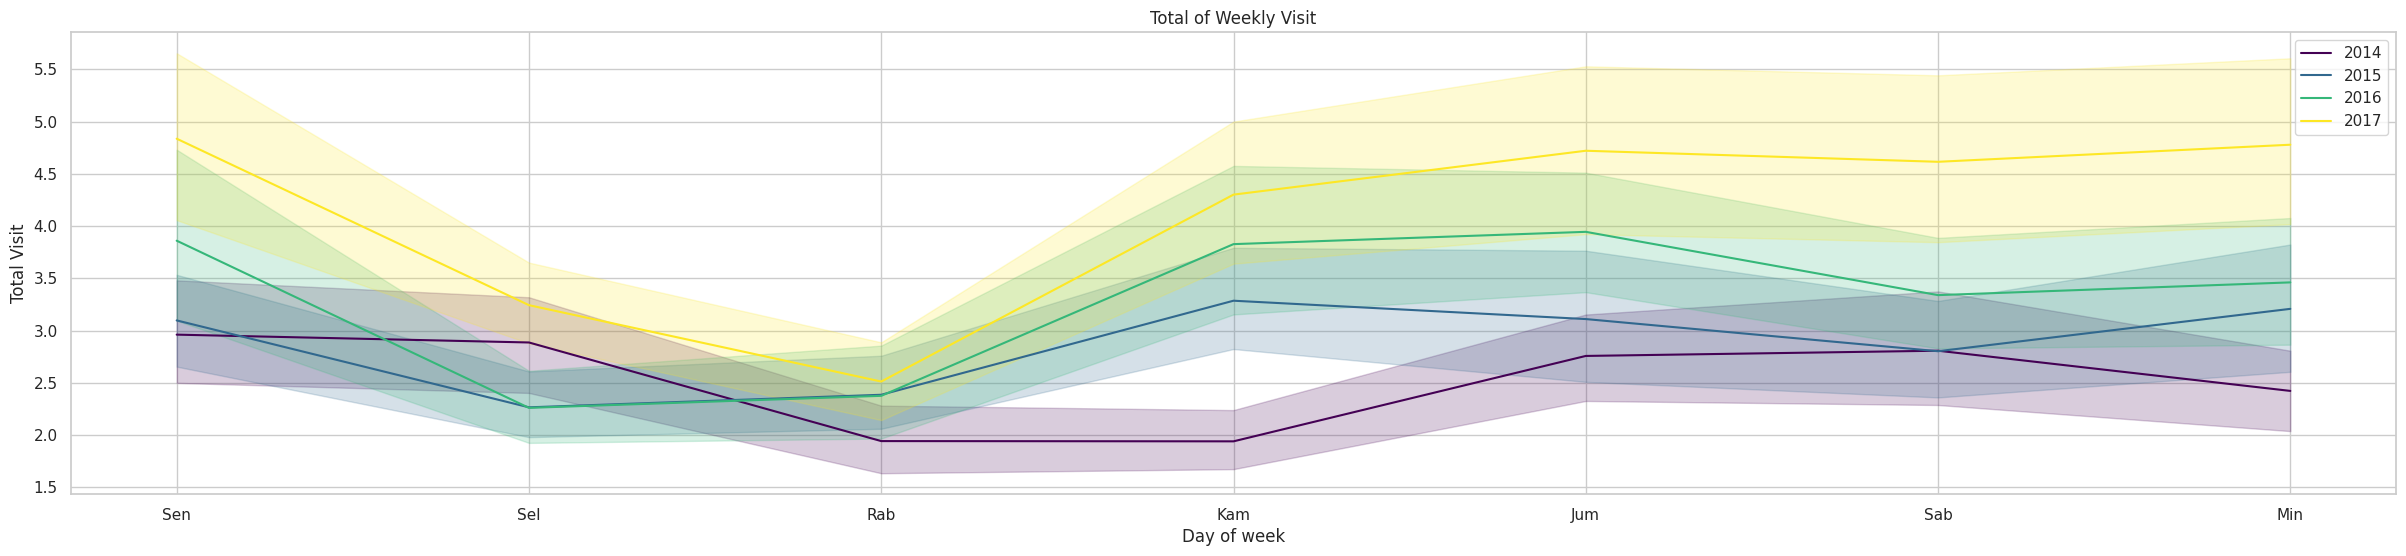

In [ ]:
# trend pola harian
# Use df_visits instead of df
df_visits['day_of_week'] = df_visits['date'].dt.dayofweek
# Tambahkan kolom tahun
df_visits['year'] = df_visits['date'].dt.year

plt.figure(figsize=(30, 6))

sns.lineplot(df_visits, x='day_of_week', y='visits', palette='viridis', hue='year')
plt.xticks(ticks=range(7), labels=['Sen', 'Sel', 'Rab', 'Kam', 'Jum', 'Sab', 'Min'])
plt.legend()
plt.title('Total of Weekly Visit')
plt.xlabel('Day of week')
plt.ylabel('Total Visit')

plt.show()

**Tren umum pola harian kunjungan:**
* Hari Senin (Sen) cenderung memiliki kunjungan tertinggi di semua tahun (2014-2017).
* Hari Selasa (Sel) hingga Rabu (Rab) mengalami penurunan kunjungan yang cukup signifikan dibanding Senin di tahun (2015-2017)
* Setelah Rabu, kunjungan mulai naik lagi dibanding selasa dan rabu, terutama di hari Kamis (Kam), Jumat (Jum), Sabtu (Sab), dan Minggu (Min) terjadi pada tahun 2015-2017.
<br>

**Implikasi untuk bisnis:**
* Hari Senin adalah hari dengan traffic paling tinggi, maka perlu strategi khusus seperti promosi atau layanan ekstra di hari tersebut.
* Hari Rabu adalah hari yang paling sepi, bisa jadi peluang untuk program khusus agar kunjungan naik.
* Akhir pekan menjadi waktu penting dengan tingkat kunjungan stabil dan meningkat, jadi perusahaan bisa memaksimalkan potensi weekend ini.


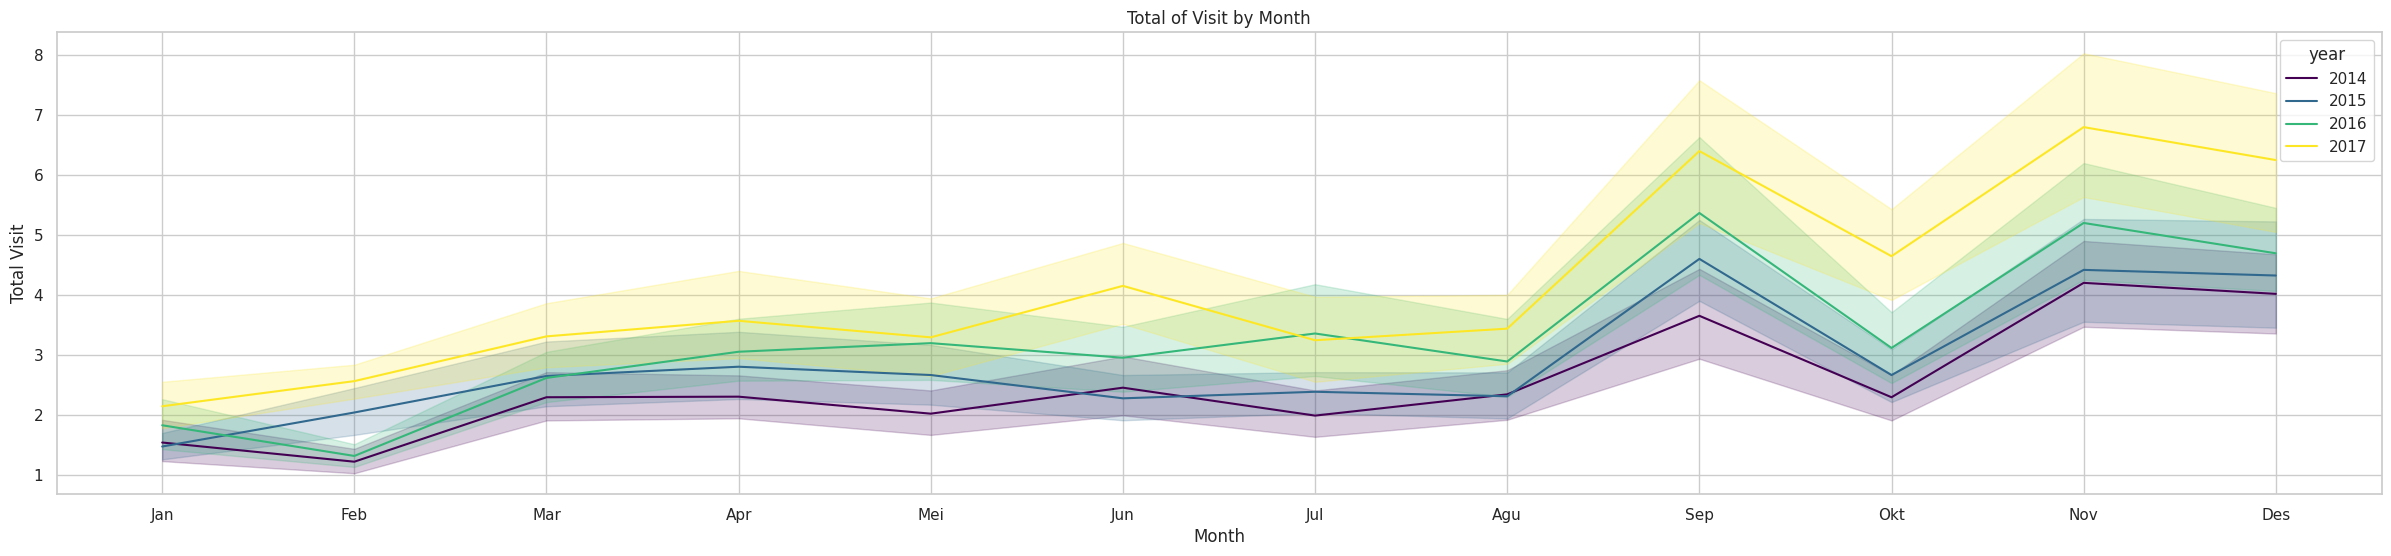

In [ ]:
#trend pola seasonal
df_visits['month'] = df_visits['date'].dt.month

plt.figure(figsize=(30, 6))

sns.lineplot(df_visits, x='month', y='visits', hue='year', palette='viridis')
plt.xticks(ticks=range(1,13), labels=['Jan','Feb','Mar','Apr','Mei','Jun','Jul','Agu','Sep','Okt','Nov','Des'])
plt.title('Total of Visit by Month')
plt.xlabel('Month')
plt.ylabel('Total Visit')

plt.show()

**Tren Seasonal Secara Umum:**
* Kunjungan relatif rendah di awal tahun (Januari dan Februari) untuk semua tahun.
* Mulai naik secara bertahap dari bulan Maret hingga Agustus dengan fluktuasi kecil.
* Terjadi lonjakan tajam pada bulan September di semua tahun, yang menandai awal musim puncak kunjungan.
* Setelah September, kunjungan tetap tinggi dengan puncak kedua biasanya terjadi pada bulan November dan Desember.
<br>

**Implikasi Bisnis:**
* fokus kegiatan pemasaran dan operasional perlu ditingkatkan mulai dari bulan September untuk memanfaatkan lonjakan kunjungan.
* Persiapan stok dan sumber daya sebaiknya diperkuat khususnya pada bulan September, November, dan Desember untuk menghindari kekurangan saat puncak kunjungan.
* Bulan Januari dan Februari bisa digunakan untuk evaluasi dan perencanaan strategi karena kunjungan relatif rendah.

ada pola musiman dalam 1 tahun, jadi karena disuruh memprediksi selama 1 bulan, dan karena ada keterbatasan di colab yang tidak bisa meload m = 365, maka saya akan mengganti nilai harian menjadi mingguan dan akan menggunakan m = 52 (1 tahun ada 52 minggu) , dan saya akan menggunakan model forecast yang bisa untuk musiman seperti SARIMA dan Prophet

## Stationery


**Augmented Dickey Fuller Test** If the p-value is lower than the threshold value (5% or 1%), we reject the null hypothesis and time series is stationary. If the p-value is higher than the threshold, we fail to reject the null hypothesis and time series is non-stationary.

karena data tersebut memuat banyak rows, maka dari itu saya jadikan data harian menjadi minguan

In [ ]:
# Filter data untuk rentang >= 2014
df_visit = df_visits[(df_visits['date'] >= '2014-01-01')]

In [ ]:
# Menghapus kolom 'day_of_week', 'year', dan 'month'
df_visit = df_visit.drop(columns=['day_of_week', 'year', 'month'])

In [ ]:
df_visit = df_visit.set_index("date")

df_visit = df_visit.resample('W').sum().astype(int)

df_visit.head()

,visits
date,
2014-01-05,3
2014-01-12,10
2014-01-19,9
2014-01-26,17
2014-02-02,7


In [ ]:
print ('Results of Dickey-Fuller Test:')
dftest = adfuller(df_visit['visits'])

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                  -4.257897
p-value                          0.000525
#Lags Used                       1.000000
Number of Observations Used    207.000000
Critical Value (1%)             -3.462342
Critical Value (5%)             -2.875606
Critical Value (10%)            -2.574267
dtype: float64


 time series is stationary, maka Bangun model SARIMA dengan d=0

## Decompossing

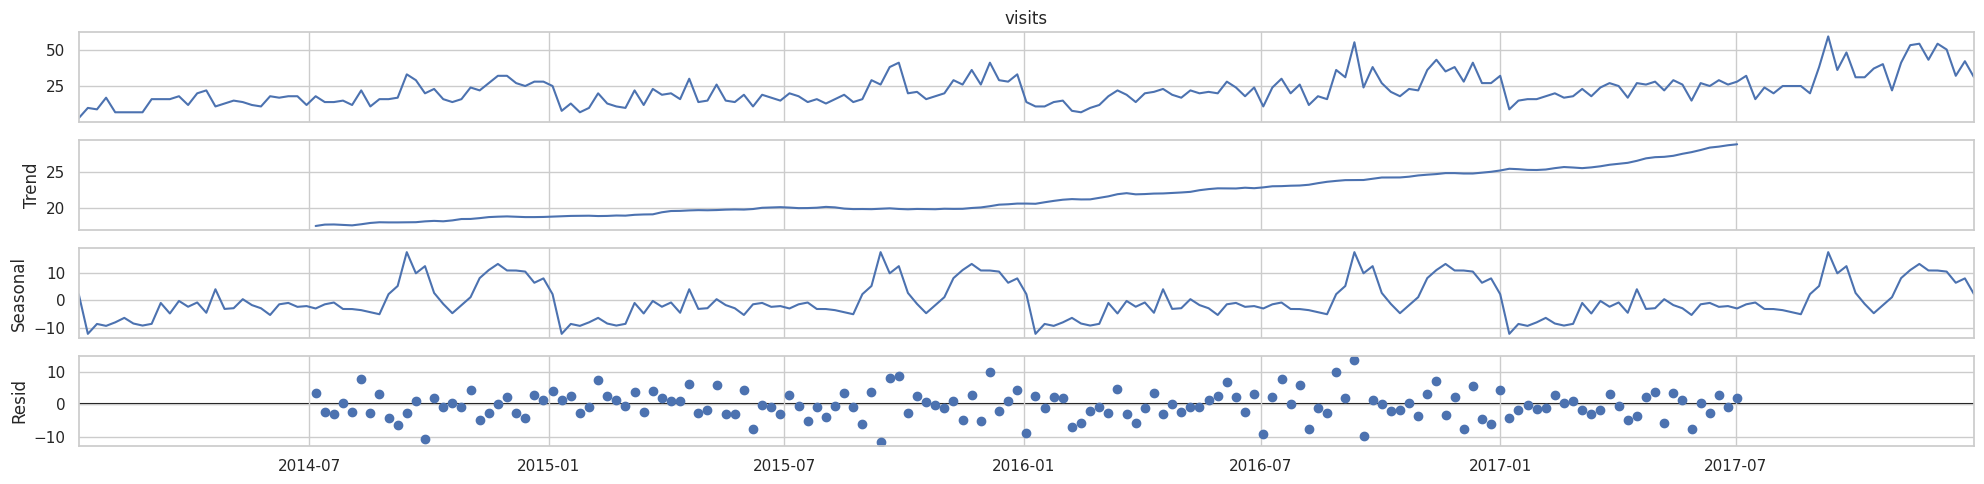

In [ ]:
df_visit_decompose = df_visit.copy()

decomposition = seasonal_decompose(df_visit_decompose['visits'], model='additive', period=52)
plt.rcParams['figure.figsize'] = 20, 5
decomposition.plot()
plt.show()

Gambar dekomposisi memperlihatkan pola musiman tahunan dengan periode sekitar 52 minggu. Dari sini kita tahu m = 52 untuk musiman tahunan.

## ACF & PACF

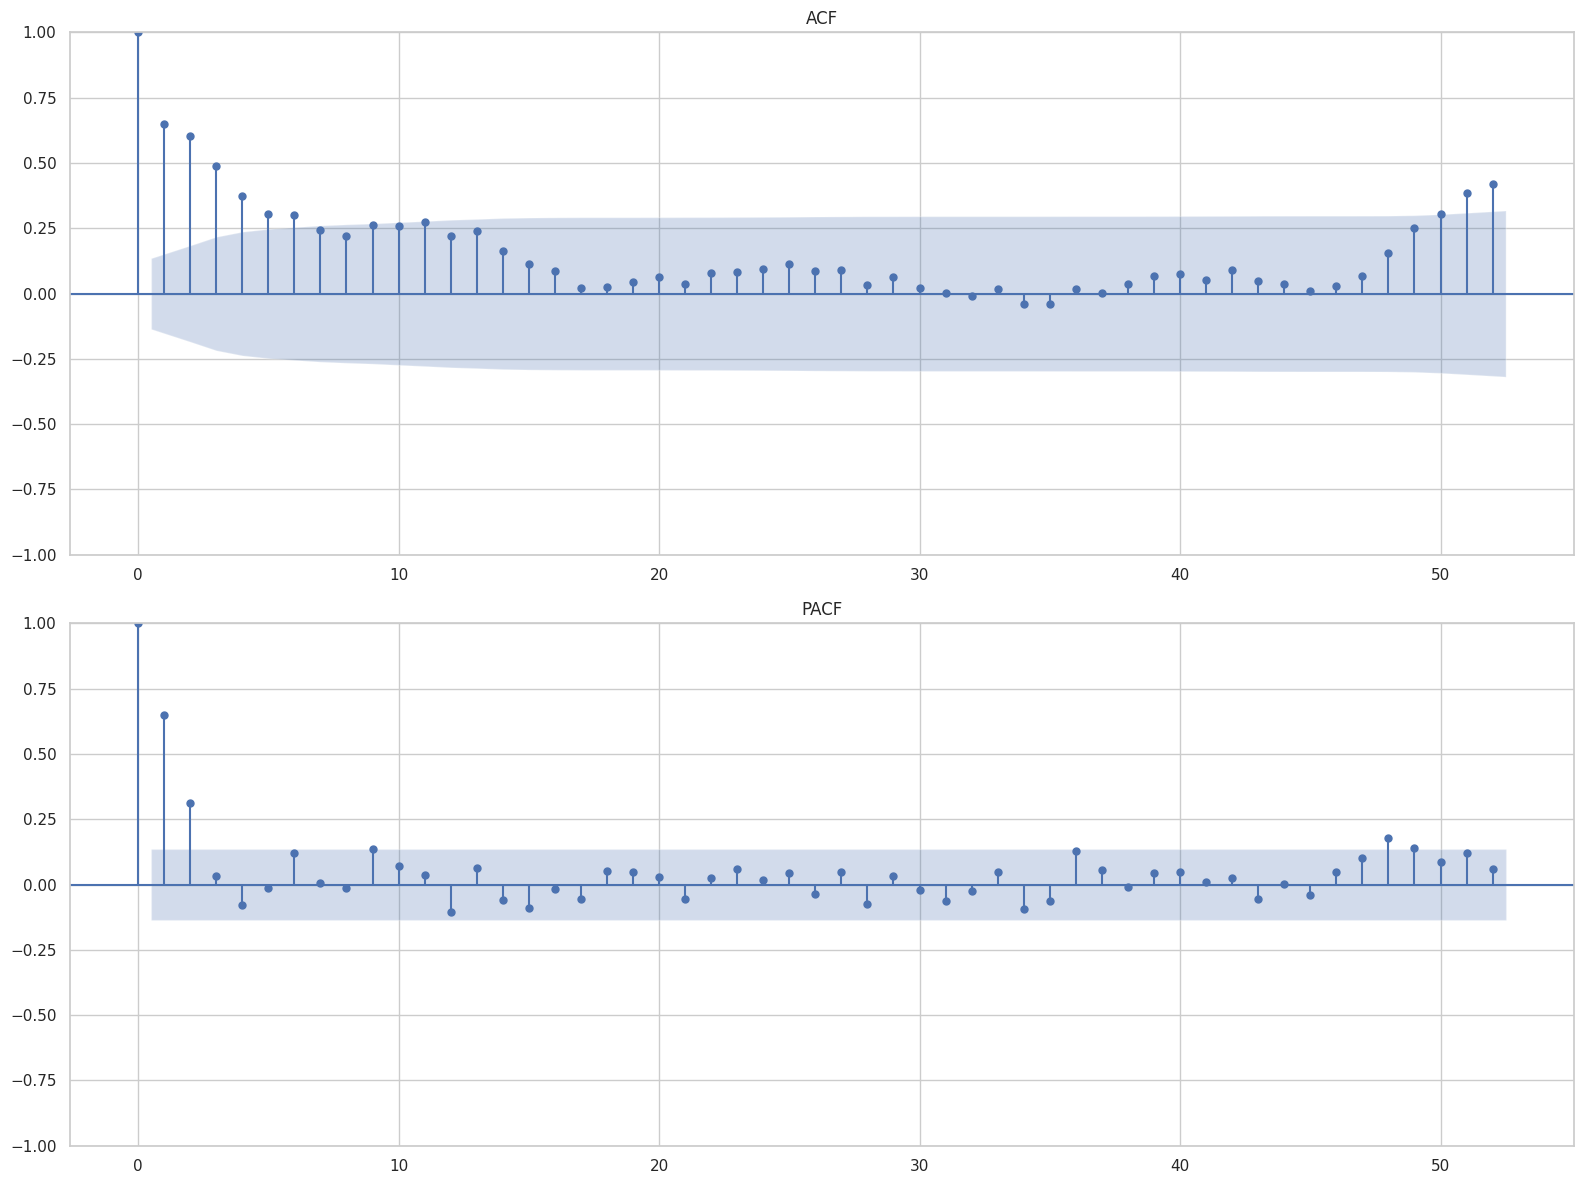

In [ ]:
plt.figure(figsize=(16,12))

plt.subplot(211)
plot_acf(df_visit, lags=52, ax=plt.gca())
plt.title('ACF')

plt.subplot(212)
plot_pacf(df_visit, lags=52, ax=plt.gca())
plt.title('PACF')

plt.tight_layout()
plt.show()

**✅ ACF Plot:**
* ACF turun secara perlahan (gradual decay) → indikasi data belum stasioner secara non-musiman.
* Ada spike berulang di sekitar lag 52 → menandakan pola musiman tahunan (mingguan).
* Pola ini menunjukkan adanya autokorelasi kuat, artinya tren dan musiman masih tersisa.

**✅ PACF Plot:**
* Spike signifikan di lag awal (1-2), kemudian cepat turun ke sekitar nol.
* Ini juga mendukung bahwa data mengandung komponen autoregressive (AR), dan belum sepenuhnya stasioner.

Karena ACF menunjukkan data belum stasioner (ada tren dan musiman),
Maka bisa dilakukan differencing, (baik differencing biasa maupun musiman) sebelum pemodelan lanjut. namun karena saya menggunakan auto arima jadi d dan D saya buat None

## Model timeseries : Seasonal ARIMA (SARIMA)

### Best Parameter

In [ ]:
!pip install pmdarima

import pmdarima as pm

# auto_arima untuk mencari parameter SARIMA terbaik
model_sar = pm.auto_arima(df_visit['visits'],
                      d=None,              # differencing non-musiman (belum dianalisis)
                      D=None,              # differencing musiman (belum dianalisis)
                      seasonal=True,    # aktifkan musiman
                      m=52,             # karena data mingguan → 1 tahun = 52 minggu
                      trend='c',        # tambahkan konstanta
                      start_p=0, start_q=0,
                      max_order=3,
                      test='adf',       # gunakan uji ADF untuk bantu deteksi d
                      stepwise=True,    # percepat proses pencarian model
                      trace=True)       # tampilkan proses pencarian

# Tampilkan ringkasan hasil
model_sar.summary()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 33.3 MB/s eta 0:00:00
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[52] intercept   : AIC=1496.664, Time=5.72 sec
 ARIMA(0,0,0)(0,0,0)[52] intercept   : AIC=1565.721, Time=0.04 sec
 ARIMA(1,0,0)(1,0,0)[52] intercept   : AIC=1447.933, Time=4.90 sec
 ARIMA(0,0,1)(0,0,1)[52] intercept   : AIC=1489.754, Time=2.15 sec
 ARIMA(0,0,0)(0,0,0)[52]             : AIC=1565.721, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[52] intercept   : AIC=1450.186, Time=0.09 sec
 ARIMA(1,0,0)(2,0,0)[52] intercept   : AIC=inf, Time=64.22 sec
 ARIMA(1,0,0)(1,0,1)[52] intercept   : AIC=1445.625, Time=26.25 sec
 ARIMA(1,0,0)(0,0,1)[52] intercept   : AIC=1449.303, Time=5.76 sec
 ARIMA(1,0,0)(2,0,1)[52] intercept   : AIC=1442.100, Time=27.59 sec
 ARIMA(1,0,0)(2,0,2)[52] intercept   : AIC=inf, Time=39.48 sec
 ARIMA(1,0,0)(1,0,2)[52] intercept   : AIC=inf, Time=22.66 sec
 ARIMA(0,0,0)(2,0,1)[52] intercept   : AIC=inf, Time=58.91 sec
 ARIMA(2,0,0)(2,0,1)[52

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  209
Model:             SARIMAX(1, 0, 1)x(2, 0, [], 52)   Log Likelihood                -695.674
Date:                             Fri, 23 May 2025   AIC                           1403.349
Time:                                     10:43:10   BIC                           1423.403
Sample:                                 01-05-2014   HQIC                          1411.456
                                      - 12-31-2017                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1497      0.141      1.062      0.288      -0.127       0.426
ar.L1          0.9794      0.020     48.559      0.000       0.940       1.019
ma.L1         -0.7850      0.063    -12.547      0.000      -0.908      -0.662
ar.S.L52       0.2548      0.049      5.195      0.000       0.159       0.351
ar.S.L104      0.4394      0.083      5.311      0.000       0.277       0.602
sigma2        38.3841      4.031      9.522      0.000      30.484      46.285
===================================================================================
Ljung-Box (L1) (Q):                   0.22   Jarque-Bera (JB):                11.94
Prob(Q):                              0.64   Prob(JB):                         0.00
Heteroskedasticity (H):               1.91   Skew:                             0.35
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Split data

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='visits'>)

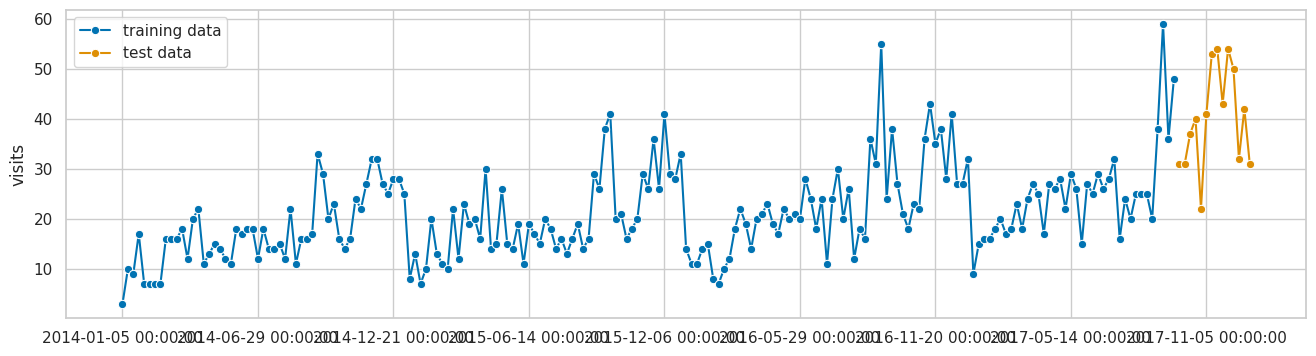

In [ ]:
# Split data
train_data = df_visit.loc[df_visit.index <= '2017-9-30'] # dataset train, use a date before the test set start
test_data = df_visit.loc[df_visit.index >= '2017-9-30'] # last 3 months for test, assigned to test_data correctly

# Pass the 'visits' column (which is a pandas Series) to plot_series
plot_series(train_data['visits'], test_data['visits'], labels=["training data", "test data"])

In [ ]:
train_data.shape, test_data.shape

((195, 1), (14, 1))

### Build SARIMA model

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Menentukan parameter yang dipilih oleh auto_arima
order = (1,0,1)  # Non-musiman
seasonal_order = (2,0,0,52)  # Musiman tahunan dengan m=52

# Membangun model SARIMA menggunakan data latih
sarima_model = SARIMAX(train_data['visits'], order=order, seasonal_order=seasonal_order)

# Melatih model
sarima_model_fit = sarima_model.fit()

# Menampilkan ringkasan model
sarima_model_fit.summary()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                              visits   No. Observations:                  195
Model:             SARIMAX(1, 0, 1)x(2, 0, [], 52)   Log Likelihood                -648.278
Date:                             Fri, 23 May 2025   AIC                           1306.556
Time:                                     10:44:01   BIC                           1322.921
Sample:                                 01-05-2014   HQIC                          1313.182
                                      - 09-24-2017                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9951      0.006    169.760      0.000       0.984       1.007
ma.L1         -0.8446      0.047    -17.895      0.000      -0.937      -0.752
ar.S.L52       0.2632      0.049      5.361      0.000       0.167       0.359
ar.S.L104      0.4528      0.083      5.443      0.000       0.290       0.616
sigma2        36.6210      4.122      8.884      0.000      28.542      44.700
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                16.08
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               2.14   Skew:                             0.38
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

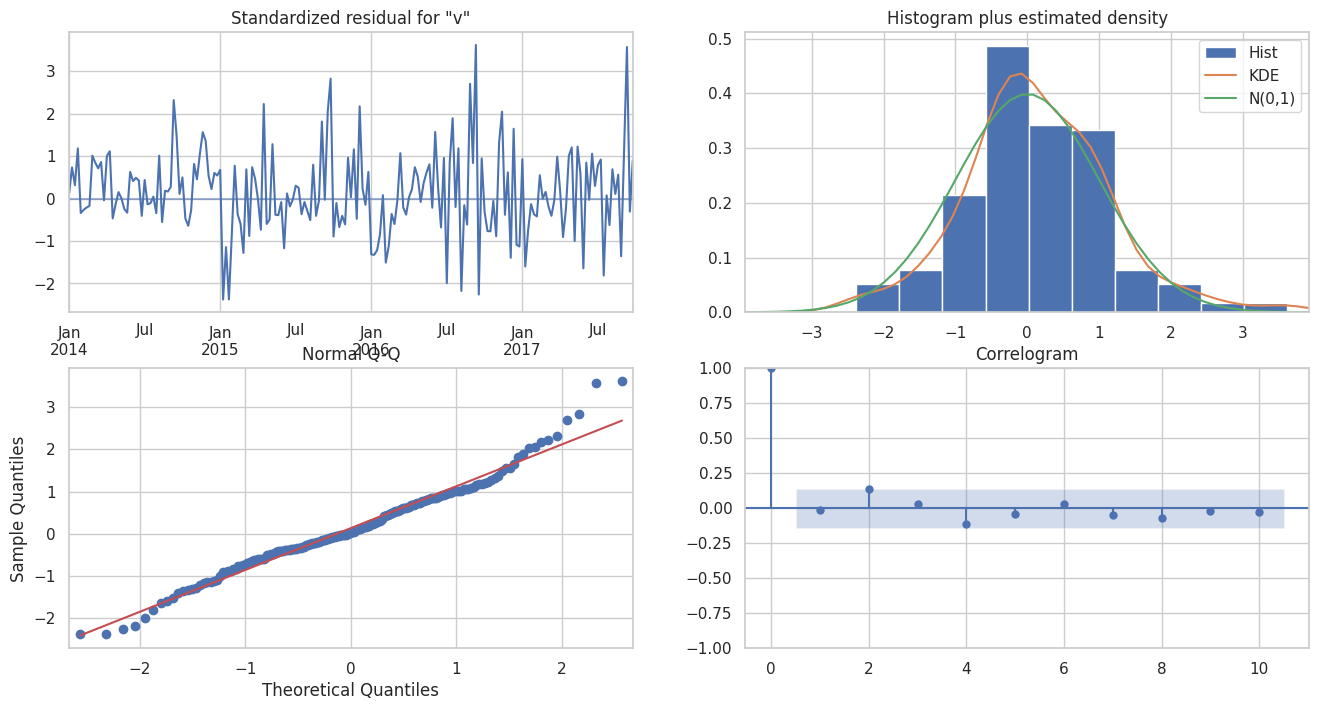

In [ ]:
sarima_model_fit.plot_diagnostics(figsize=(16, 8))
plt.savefig('modeldiagnostics')
plt.show()

### Evaluation

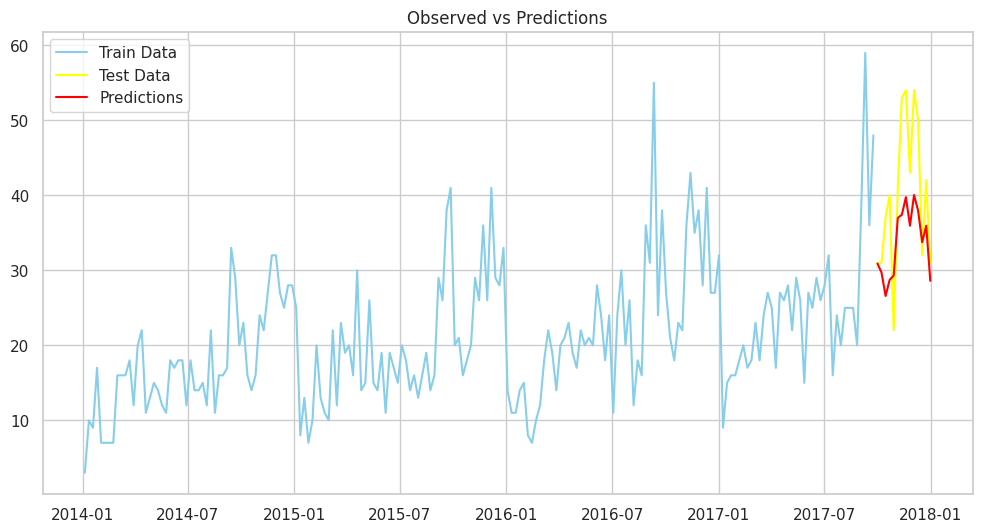

Mean Absolute Error (MAE): 7.67893800107985
Mean Absolute Percentage Error (MAPE): 18.11 %


In [ ]:
# Prediksi untuk rentang data test (dan bisa sampai akhir test data)
pred = sarima_model_fit.get_prediction(start=test_data.index[0], end=test_data.index[-1])

# Dapatkan rata-rata prediksi dan confidence interval-nya
pred_mean = pred.predicted_mean
conf_int = pred.conf_int()

# Plot hasil prediksi dan data asli
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data['visits'], label='Train Data', color='skyblue')
plt.plot(test_data.index, test_data['visits'], label='Test Data', color='yellow')
plt.plot(pred_mean.index, pred_mean, label='Predictions', color='red')
plt.title('Observed vs Predictions')
plt.legend(loc='best')
plt.show()

# Hitung error prediksi (hanya pada test set)
mae_sarima = mean_absolute_error(test_data['visits'], pred_mean)
mape_sarima = mean_absolute_percentage_error(test_data['visits'], pred_mean)

print(f"Mean Absolute Error (MAE): {mae_sarima}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_sarima * 100:.2f} %")

## Model Time series : Prophet

In [ ]:
weekly_visit = df_visit.reset_index()

In [ ]:
# Rename columns to 'ds' and 'y' for Prophet
weekly_visit = weekly_visit.rename(columns={'date': 'ds', 'visits': 'y'})
weekly_visit.head()

,ds,y
0,2014-01-05,3
1,2014-01-12,10
2,2014-01-19,9
3,2014-01-26,17
4,2014-02-02,7


### Split data

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='y'>)

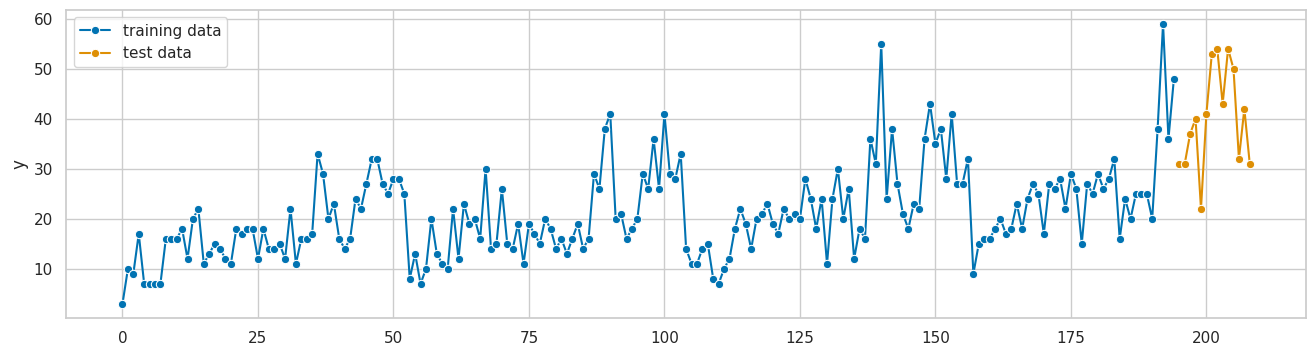

In [ ]:
# Split data
train_df = weekly_visit[weekly_visit['ds'] <= '2017-9-30'] # dataset to train, use a date before the test set start
test_df = weekly_visit[weekly_visit['ds'] >= '2017-9-30'] # last 3 months for test, assigned to test_data correctly

# Pass the 'visits' column (which is a pandas Series) to plot_series
# Make sure to pass the 'y' column (the visits data) for plotting
plot_series(train_df['y'], test_df['y'], labels=["training data", "test data"])

### Build Prophet model

In [ ]:
!pip install prophet
from prophet import Prophet

model_prophet = Prophet()
model_prophet.fit(train_df)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcr9od1r7/qp10ceoo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcr9od1r7/yghlfr3a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54221', 'data', 'file=/tmp/tmpcr9od1r7/qp10ceoo.json', 'init=/tmp/tmpcr9od1r7/yghlfr3a.json', 'output', 'file=/tmp/tmpcr9od1r7/prophet_modelvdpukhki/prophet_model-20250523104406.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:44:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:44:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
future = model_prophet.make_future_dataframe(periods=15, freq='W')

In [ ]:
forecast = model_prophet.predict(future)

In [ ]:
forecast[["ds","yhat","yhat_lower","yhat_upper"]].tail()

,ds,yhat,yhat_lower,yhat_upper
205,2017-12-10,38.334211,31.815803,44.432418
206,2017-12-17,37.804651,31.546038,43.676975
207,2017-12-24,34.640214,28.706032,41.092588
208,2017-12-31,28.661493,22.246675,34.732593
209,2018-01-07,22.453972,16.159332,28.687183


### Evaluation

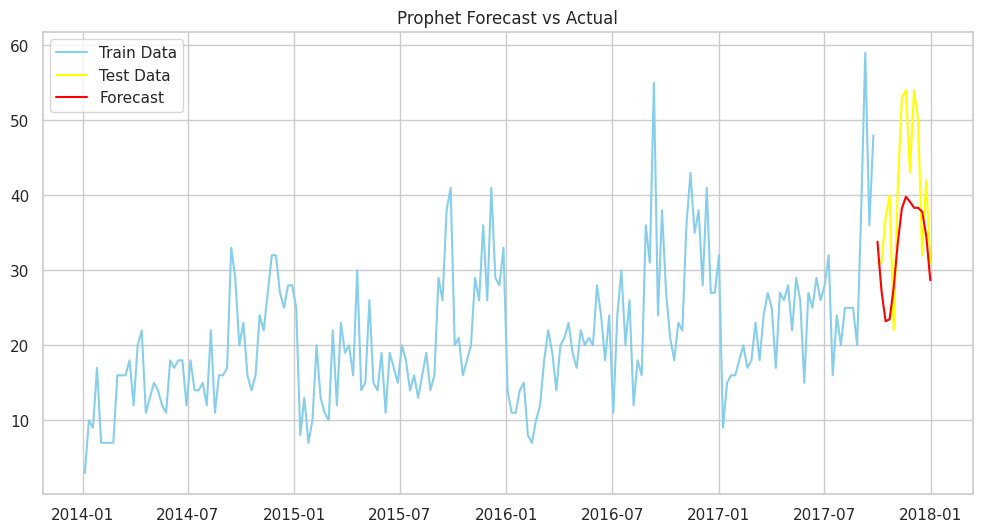

Mean Absolute Error (MAE): 8.974
Mean Absolute Percentage Error (MAPE): 21.61%


In [ ]:
forecast_test = forecast[forecast['ds'].isin(test_df['ds'])]

plt.figure(figsize=(12,6))
plt.plot(train_df['ds'], train_df['y'], label='Train Data', color='skyblue')
plt.plot(test_df['ds'], test_df['y'], label='Test Data', color='yellow')
plt.plot(forecast_test['ds'], forecast_test['yhat'], label='Forecast', color='red')
plt.legend()
plt.title('Prophet Forecast vs Actual')
plt.show()

#matriks evaluasi
merged = test_df.merge(forecast[['ds', 'yhat']], on='ds', how='inner')

mae = mean_absolute_error(merged['y'], merged['yhat'])
mape = mean_absolute_percentage_error(merged['y'], merged['yhat']) * 100

print(f"Mean Absolute Error (MAE): {mae:.3f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

## Predict for 1 month use the best model

berdasarkan hasil prediksi sebelumnya, model terbaik untuk menggambarkan jumlah visit yaitu model sarima (p=1, d=0, q=1) (P=2, D=0, Q=0, S=52). maka prediksi jumlah visit untuk 1 bulan kedepan yaitu

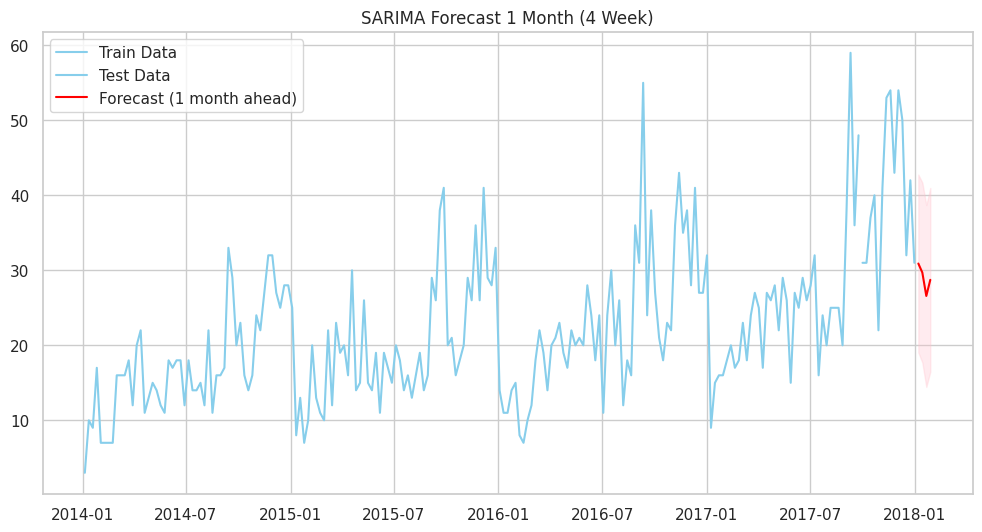

In [ ]:
import pandas as pd

# Mulai prediksi dari hari setelah data test terakhir
start_forecast = test_data.index[-1] + pd.Timedelta(weeks=1)

# Jumlah periode yang ingin diprediksi (4 minggu ke depan)
steps = 4

# Buat prediksi 4 minggu ke depan
forecast_obj = sarima_model_fit.get_forecast(steps=steps)

# Ambil nilai prediksi rata-rata dan confidence interval
forecast_mean = forecast_obj.predicted_mean
forecast_conf_int = forecast_obj.conf_int()

# Buat index tanggal prediksi berdasarkan last date + step weeks
forecast_index = pd.date_range(start=start_forecast, periods=steps, freq='W')

# Update index prediksi dengan tanggal
forecast_mean.index = forecast_index
forecast_conf_int.index = forecast_index

# Visualisasi hasil prediksi 1 bulan kedepan
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data['visits'], label='Train Data', color='skyblue')
plt.plot(test_data.index, test_data['visits'], label='Test Data', color='skyblue')
plt.plot(forecast_mean.index, forecast_mean, label='Forecast (1 month ahead)', color='red')
plt.fill_between(forecast_conf_int.index,
                 forecast_conf_int.iloc[:, 0],
                 forecast_conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.title('SARIMA Forecast 1 Month (4 Week)')
plt.legend(loc='best')
plt.show()

In [ ]:
#nilai prediksi
forecast_mean.astype(int)

,predicted_mean
2018-01-07,30
2018-01-14,29
2018-01-21,26
2018-01-28,28


Model SARIMA ini memprediksi jumlah kunjungan selama Januari 2018 berada di kisaran 25-30. Terlihat penurunan kunjungan dari bulan sebelumnya (September hingga Desember), namun pola serupa di Januari tahun-tahun sebelumnya cenderung stabil atau sedikit meningkat. Hal ini wajar terjadi karena pengaruh musiman di akhir tahun. Sebagai rekomendasi bisnis, sebaiknya persiapkan strategi promosi atau peningkatan layanan pada awal tahun untuk memanfaatkan tren kenaikan kunjungan setelah periode penurunan.

# Transaction Dataset

In [ ]:
## 1. Persiapan Data
# Hitung transaction harian (asumsikan 1 1 transaksi unik dihitung 1 kali per hari)
daily_transactions = df.groupby(df['Order Date'].dt.date)['Order ID'].nunique().reset_index()
daily_transactions.columns = ['date', 'transactions']
daily_transactions['date'] = pd.to_datetime(daily_transactions['date'])

daily_transactions.head(10)

,date,transactions
0,2014-01-03,1
1,2014-01-04,1
2,2014-01-05,1
3,2014-01-06,3
4,2014-01-07,1
5,2014-01-09,1
6,2014-01-10,1
7,2014-01-11,1
8,2014-01-13,3
9,2014-01-14,1


## Preprocessing data

In [ ]:
# Cek apakah data sudah terurut berdasarkan tanggal
is_sorted = daily_transactions['date'].is_monotonic_increasing
print(f"Data sudah terurut berdasarkan tanggal: {is_sorted}")

Data sudah terurut berdasarkan tanggal: True


In [ ]:
# Cek missing values di seluruh kolom
missing_values = daily_transactions.isnull().sum()
print("Jumlah missing value per kolom:")
print(missing_values)

Jumlah missing value per kolom:
date            0
transactions    0
dtype: int64


In [ ]:
# Jika ingin cek apakah ada tanggal yang hilang dalam deret waktu
# Use 'daily_transactions' and its 'date' column instead of trying to access 'Date' in 'df'
date_range = pd.date_range(start=daily_transactions['date'].min(), end=daily_transactions['date'].max(), freq='D')
missing_dates = date_range.difference(daily_transactions['date']) # Check difference with 'date' column in daily_data
print(f"Jumlah tanggal hilang dalam rentang data: {len(missing_dates)}")
if len(missing_dates) > 0:
    print("Tanggal hilang:", missing_dates)

Jumlah tanggal hilang dalam rentang data: 277
Tanggal hilang: DatetimeIndex(['2014-01-08', '2014-01-12', '2014-01-17', '2014-01-21',
               '2014-01-22', '2014-01-23', '2014-01-24', '2014-01-25',
               '2014-01-29', '2014-02-05',
               ...
               '2017-08-30', '2017-09-06', '2017-09-27', '2017-10-10',
               '2017-10-11', '2017-10-18', '2017-10-24', '2017-10-25',
               '2017-11-08', '2017-12-12'],
              dtype='datetime64[ns]', length=277, freq=None)


Berdasarkan output yang diberikan, terdapat 277 tanggal yang hilang dari dataset dalam rentang waktu 2014-2017. Ini adalah jumlah yang signifikan dan perlu ditangani untuk analisis time series yang akurat. Disini saya akan menggunakan interpolasi linier untuk menggantikan nilai yanghilang. Interpolasi adalah metode yang paling umum dan tepat untuk mengisi nilai yang hilang secara kontinu pada deret waktu dengan asumsi bahwa perubahan antar titik data relatif halus dan linear. Interpolasi linear mengestimasi nilai di titik hilang berdasarkan nilai sebelum dan sesudahnya, sehingga memberikan prediksi yang realistis dibanding mengisi dengan nilai tetap atau menghapus data.

In [ ]:
# Buat deret waktu lengkap
date_range_transactions = pd.date_range(start=daily_transactions['date'].min(), end=daily_transactions['date'].max(), freq='D')
full_dates_visits = pd.DataFrame({'date': date_range_transactions})

# Gabungkan dengan data asli
full_daily_transactions = pd.merge(full_dates_visits, daily_transactions, on='date', how='left')

# Set the 'date' column as the index before interpolating
full_daily_transactions.set_index('date', inplace=True)

# Lakukan interpolasi linear untuk mengisi nilai NaN
df_transactions = full_daily_transactions.interpolate(method='linear').reset_index()

df_transactions.head(10)

,date,transactions
0,2014-01-03,1.0
1,2014-01-04,1.0
2,2014-01-05,1.0
3,2014-01-06,3.0
4,2014-01-07,1.0
5,2014-01-08,1.0
6,2014-01-09,1.0
7,2014-01-10,1.0
8,2014-01-11,1.0
9,2014-01-12,2.0


## EDA

**Identifikasi pola harian, mingguan, atau musiman yang mungkin berpengaruh pada bisnis.**

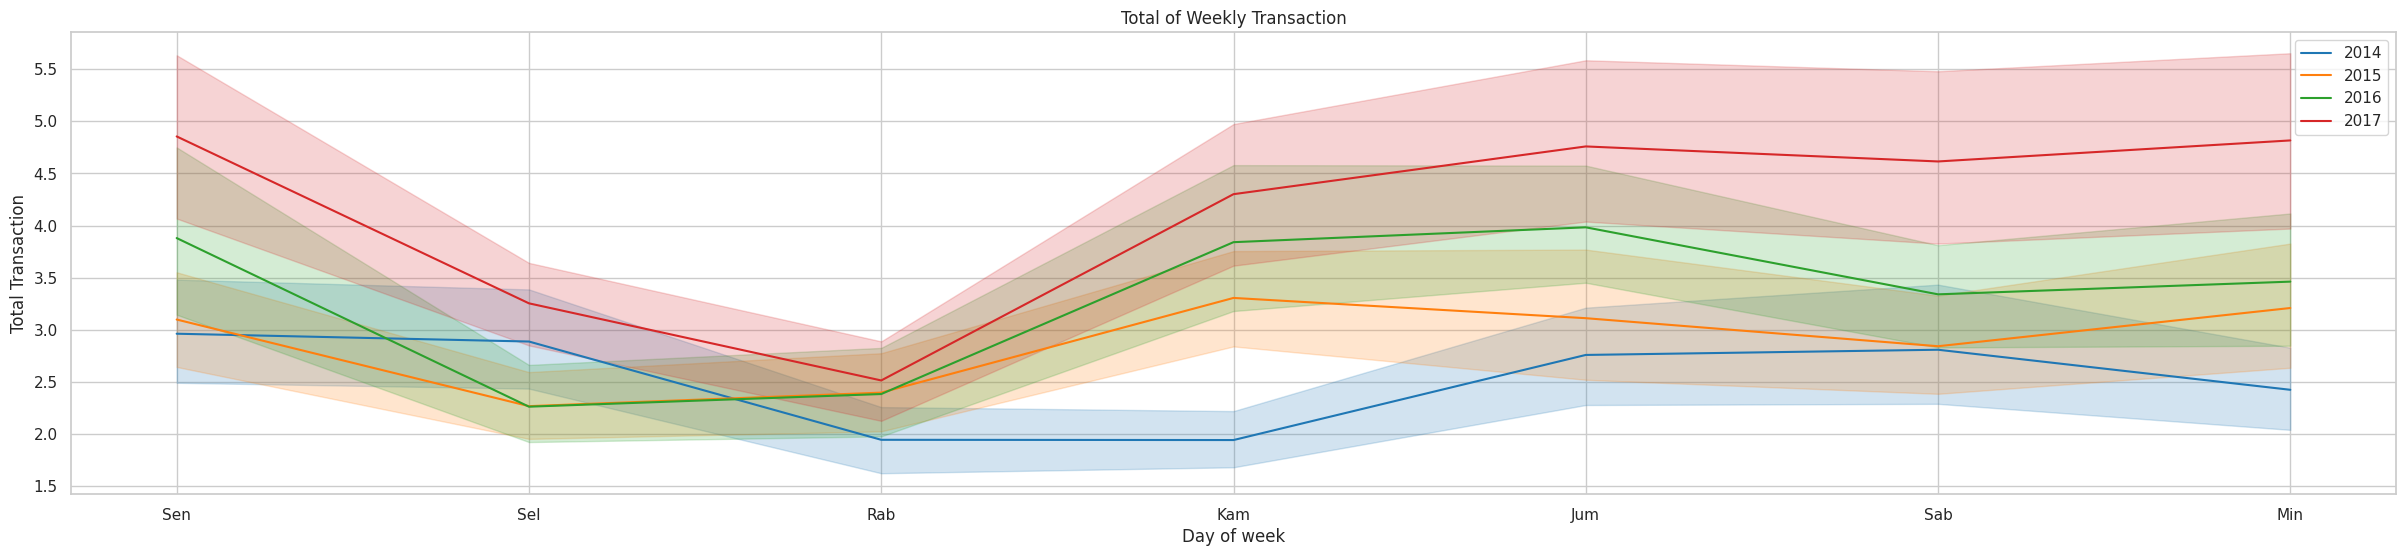

In [ ]:
# trend pola harian
# Use df_transactions instead of df
df_transactions['day_of_week'] = df_transactions['date'].dt.dayofweek
# Tambahkan kolom tahun
df_transactions['year'] = df_transactions['date'].dt.year

plt.figure(figsize=(30, 6))

sns.lineplot(df_transactions, x='day_of_week', y='transactions', palette='tab10', hue='year')
plt.xticks(ticks=range(7), labels=['Sen', 'Sel', 'Rab', 'Kam', 'Jum', 'Sab', 'Min'])
plt.legend()
plt.title('Total of Weekly Transaction')
plt.xlabel('Day of week')
plt.ylabel('Total Transaction')

plt.show()

**Tren umum pola mingguan transaksi per hari:**  
* Hari Senin (Sen) memiliki transaksi tertinggi di semua tahun (2014-2017).  
* Transaksi turun pada hari Selasa (Sel) dan Rabu (Rab).  
* Setelah Rabu, transaksi mulai naik kembali dan relatif stabil sampai Minggu pada tahun 2015-2017.  
* Tahun 2017 menunjukkan transaksi yang lebih tinggi, terutama di akhir pekan.  

**Implikasi bisnis:**  
* Fokus promosi dan layanan ekstra pada hari Senin karena traffic tertinggi.  
* Hari Selasa dan Rabu perlu program khusus untuk tingkatkan transaksi.  
* Akhir pekan adalah peluang penting dengan transaksi stabil dan meningkat.  

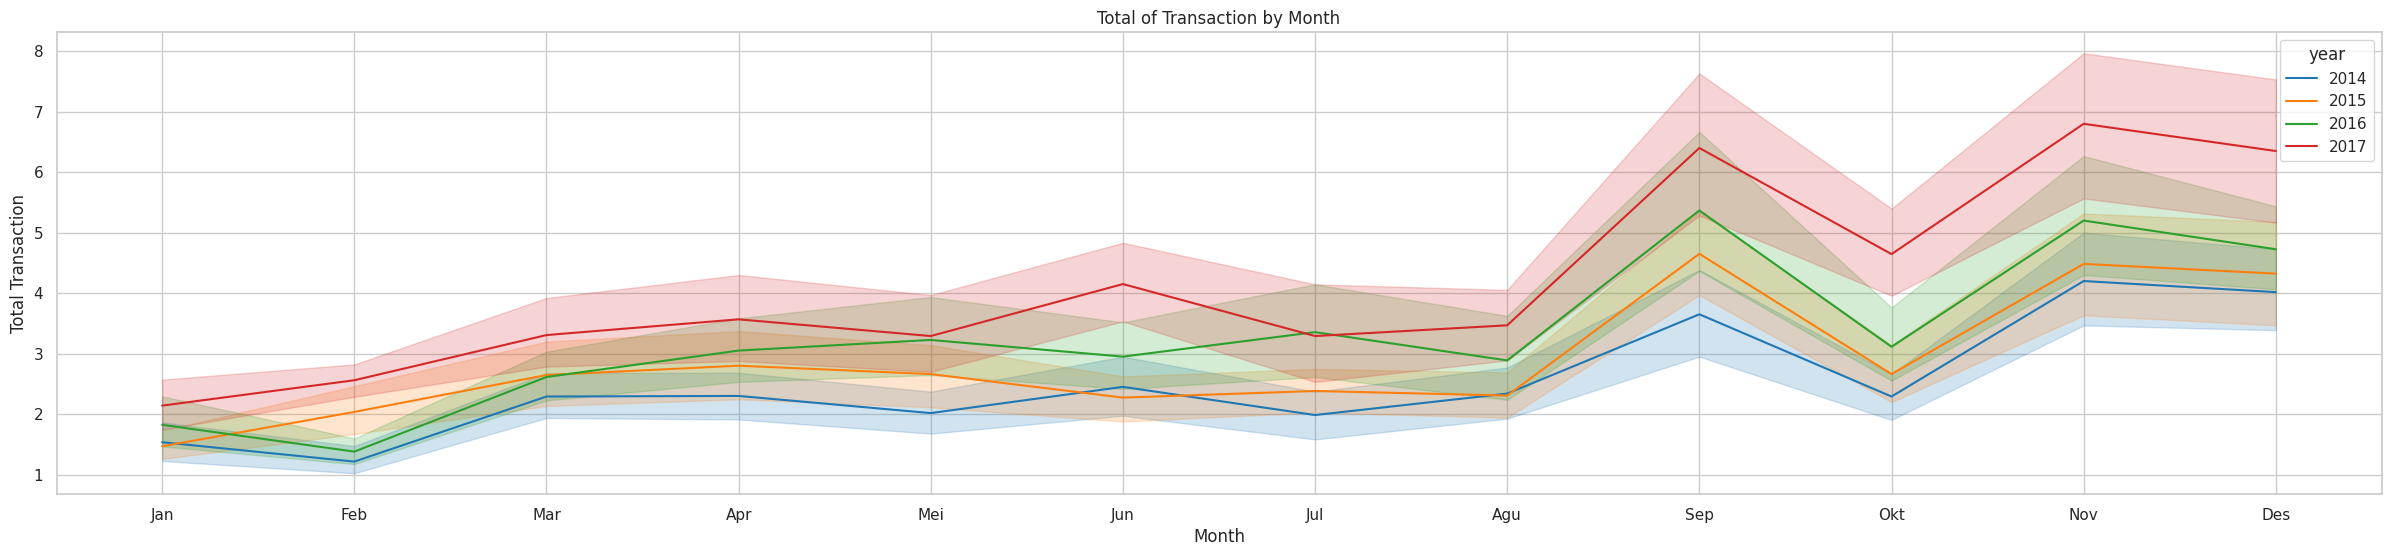

In [ ]:
#trend pola seasonal
df_transactions['month'] = df_transactions['date'].dt.month

plt.figure(figsize=(30, 6))

sns.lineplot(df_transactions, x='month', y='transactions', hue='year', palette='tab10')
plt.xticks(ticks=range(1,13), labels=['Jan','Feb','Mar','Apr','Mei','Jun','Jul','Agu','Sep','Okt','Nov','Des'])
plt.title('Total of Transaction by Month')
plt.xlabel('Month')
plt.ylabel('Total Transaction')

plt.show()

**Tren Seasonal Secara Umum:**  
* Total transaksi relatif rendah di awal tahun (Januari dan Februari) untuk semua tahun.  
* Mulai naik secara bertahap dari bulan Maret hingga Agustus dengan fluktuasi kecil.  
* Terjadi lonjakan tajam pada bulan September di semua tahun, menandai awal musim puncak transaksi.  
* Setelah September, transaksi tetap tinggi dengan puncak kedua biasanya terjadi pada bulan November dan Desember.  

**Implikasi Bisnis:**  
* Fokus kegiatan pemasaran dan operasional perlu ditingkatkan mulai bulan September untuk memanfaatkan lonjakan transaksi.  
* Persiapan stok dan sumber daya sebaiknya diperkuat khususnya pada bulan September, November, dan Desember agar tidak kekurangan saat puncak transaksi.  
* Bulan Januari dan Februari bisa digunakan untuk evaluasi dan perencanaan strategi karena transaksi relatif rendah.  

## Stationery


**Augmented Dickey Fuller Test** If the p-value is lower than the threshold value (5% or 1%), we reject the null hypothesis and time series is stationary. If the p-value is higher than the threshold, we fail to reject the null hypothesis and time series is non-stationary.

In [ ]:
# Menghapus kolom 'day_of_week', 'year', dan 'month'
df_transaction = df_transactions.drop(columns=['day_of_week', 'year', 'month'])

In [ ]:
df_transaction = df_transaction.set_index("date")

df_transaction = df_transaction.resample('W').sum().astype(int)

df_transaction.head()

,transactions
date,
2014-01-05,3
2014-01-12,10
2014-01-19,9
2014-01-26,17
2014-02-02,7


In [ ]:
print ('Results of Dickey-Fuller Test:')
dftest = adfuller(df_transaction['transactions'])

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                  -4.246579
p-value                          0.000549
#Lags Used                       1.000000
Number of Observations Used    207.000000
Critical Value (1%)             -3.462342
Critical Value (5%)             -2.875606
Critical Value (10%)            -2.574267
dtype: float64


 time series is stationary, maka bangun model SARIMA dengan d=0

## Decompossing

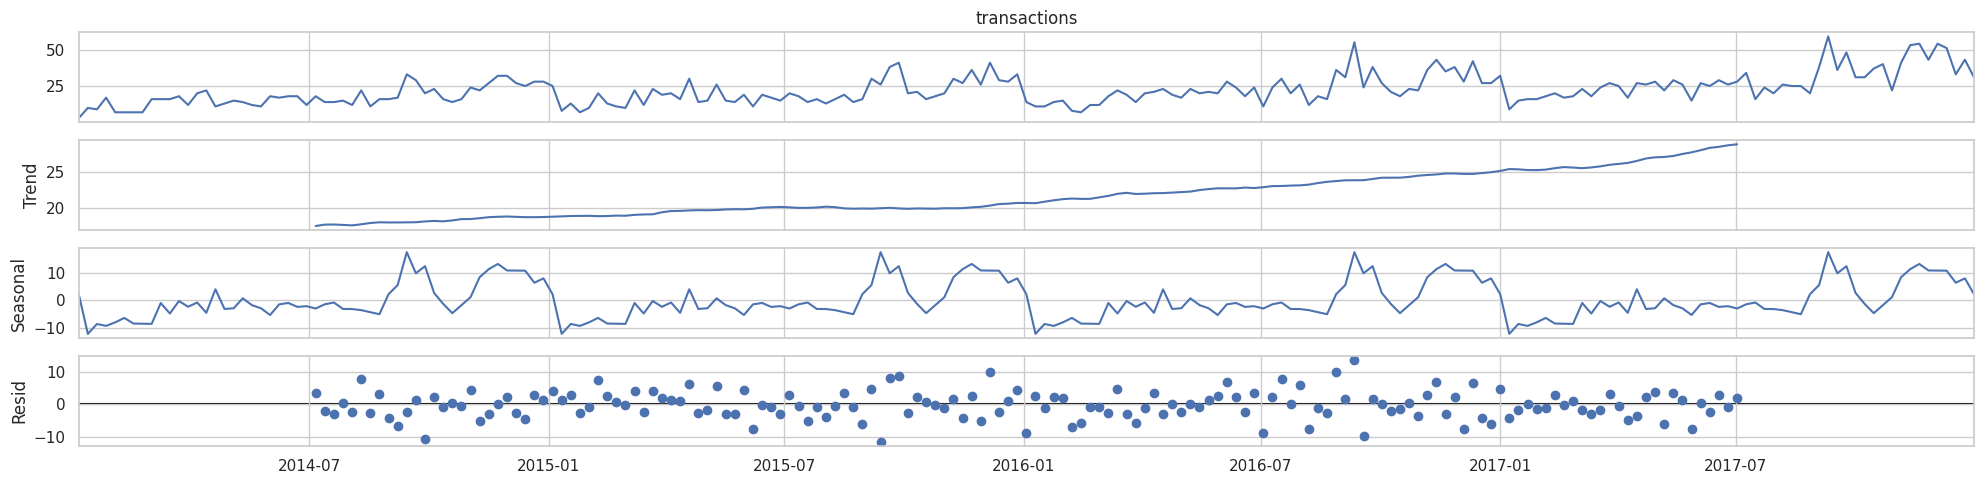

In [ ]:
df_transaction_decompose = df_transaction.copy()

decomposition = seasonal_decompose(df_transaction_decompose['transactions'], model='additive', period=52)
plt.rcParams['figure.figsize'] = 20, 5
decomposition.plot()
plt.show()

Gambar dekomposisi memperlihatkan pola musiman tahunan dengan periode sekitar 52 minggu. Dari sini kita tahu m = 52 untuk musiman tahunan.

## ACF & PACF

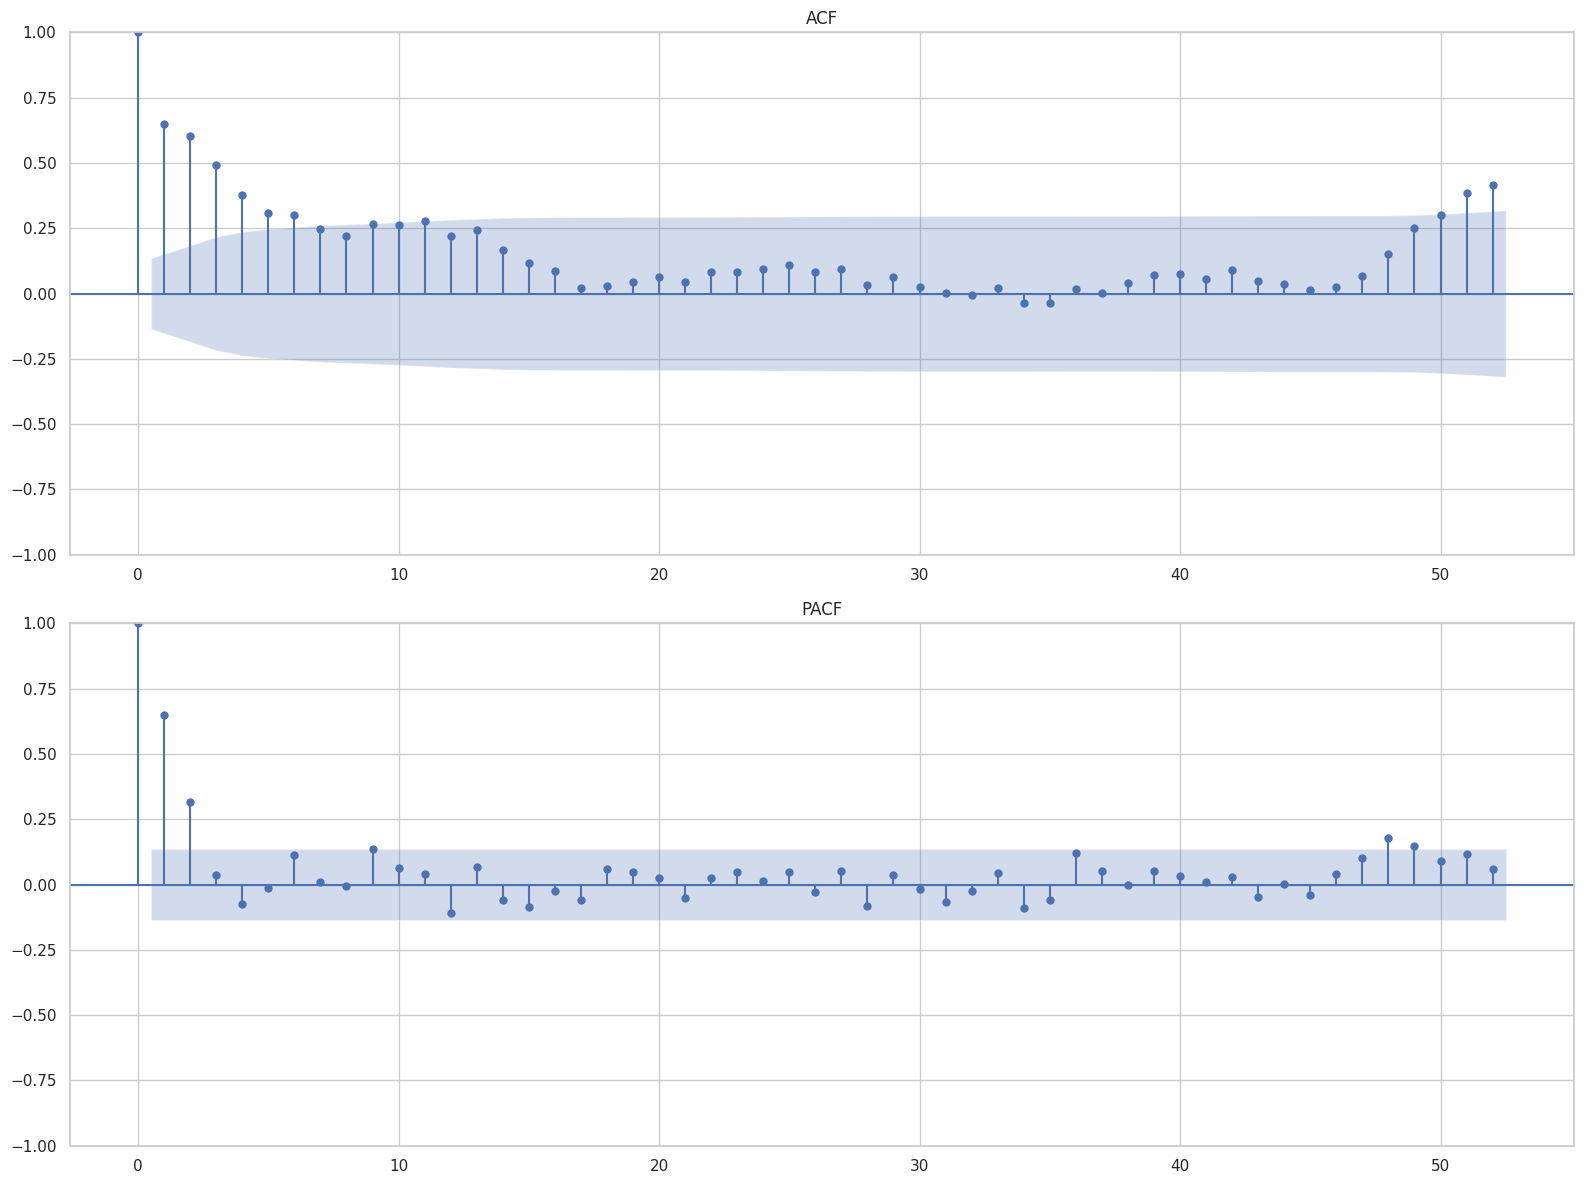

In [ ]:
plt.figure(figsize=(16,12))

plt.subplot(211)
plot_acf(df_transaction, lags=52, ax=plt.gca())
plt.title('ACF')

plt.subplot(212)
plot_pacf(df_transaction, lags=52, ax=plt.gca())
plt.title('PACF')

plt.tight_layout()
plt.show()

**✅ ACF Plot:**  
* ACF menunjukkan penurunan lambat (gradual decay), menandakan data belum stasioner secara non-musiman.  
* Terdapat spike berulang pada sekitar lag 52 yang menunjukkan pola musiman tahunan pada data mingguan.  
* Pola ini mengindikasikan autokorelasi yang kuat, sehingga tren dan musiman masih ada dalam data.

**✅ PACF Plot:**  
* Spike signifikan di lag 1 dan 2, lalu cepat turun mendekati nol.  
* Ini menunjukkan adanya komponen autoregressive (AR) dalam data dan data belum sepenuhnya stasioner.

Karena ACF dan PACF mengindikasikan data belum stasioner dengan adanya tren dan musiman. Maka bisa dilakukan differencing, (baik differencing biasa maupun musiman) sebelum pemodelan lanjut. namun karena saya menggunakan auto arima jadi d dan D saya buat None

## Model timeseries : Seasonal ARIMA (SARIMA)

### Best parameter

In [ ]:
# auto_arima untuk mencari parameter SARIMA terbaik
model_sarima = pm.auto_arima(df_transaction['transactions'],
                      d=None,              # differencing non-musiman (belum dianalisis)
                      D=None,              # differencing musiman (belum dianalisis)
                      seasonal=True,    # aktifkan musiman
                      m=52,             # karena data mingguan → 1 tahun = 52 minggu
                      trend='c',        # tambahkan konstanta
                      start_p=0, start_q=0,
                      max_order=3,
                      test='adf',       # gunakan uji ADF untuk bantu deteksi d
                      stepwise=True,    # percepat proses pencarian model
                      trace=True)       # tampilkan proses pencarian

# Tampilkan ringkasan hasil
model_sarima.summary()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[52] intercept   : AIC=1498.617, Time=7.24 sec
 ARIMA(0,0,0)(0,0,0)[52] intercept   : AIC=1567.626, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[52] intercept   : AIC=1451.002, Time=3.10 sec
 ARIMA(0,0,1)(0,0,1)[52] intercept   : AIC=1492.323, Time=1.61 sec
 ARIMA(0,0,0)(0,0,0)[52]             : AIC=1567.626, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[52] intercept   : AIC=1453.197, Time=0.09 sec
 ARIMA(1,0,0)(2,0,0)[52] intercept   : AIC=inf, Time=20.07 sec
 ARIMA(1,0,0)(1,0,1)[52] intercept   : AIC=inf, Time=14.59 sec
 ARIMA(1,0,0)(0,0,1)[52] intercept   : AIC=1452.353, Time=5.04 sec
 ARIMA(1,0,0)(2,0,1)[52] intercept   : AIC=1445.405, Time=67.13 sec
 ARIMA(1,0,0)(2,0,2)[52] intercept   : AIC=inf, Time=69.44 sec
 ARIMA(1,0,0)(1,0,2)[52] intercept   : AIC=inf, Time=70.88 sec
 ARIMA(0,0,0)(2,0,1)[52] intercept   : AIC=inf, Time=47.55 sec
 ARIMA(2,0,0)(2,0,1)[52] intercept   : AIC=1416.823, Time=73.15 sec
 ARIMA(2,0,0)(1,0,1)[52] intercept   

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  209
Model:             SARIMAX(1, 0, 1)x(2, 0, [], 52)   Log Likelihood                -696.484
Date:                             Fri, 23 May 2025   AIC                           1404.969
Time:                                     11:20:00   BIC                           1425.023
Sample:                                 01-05-2014   HQIC                          1413.076
                                      - 12-31-2017                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1362      0.134      1.015      0.310      -0.127       0.399
ar.L1          0.9813      0.019     50.499      0.000       0.943       1.019
ma.L1         -0.7928      0.062    -12.876      0.000      -0.913      -0.672
ar.S.L52       0.2560      0.049      5.190      0.000       0.159       0.353
ar.S.L104      0.4408      0.083      5.311      0.000       0.278       0.604
sigma2        38.5979      4.121      9.366      0.000      30.521      46.675
===================================================================================
Ljung-Box (L1) (Q):                   0.34   Jarque-Bera (JB):                10.85
Prob(Q):                              0.56   Prob(JB):                         0.00
Heteroskedasticity (H):               1.92   Skew:                             0.34
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Split data

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='transactions'>)

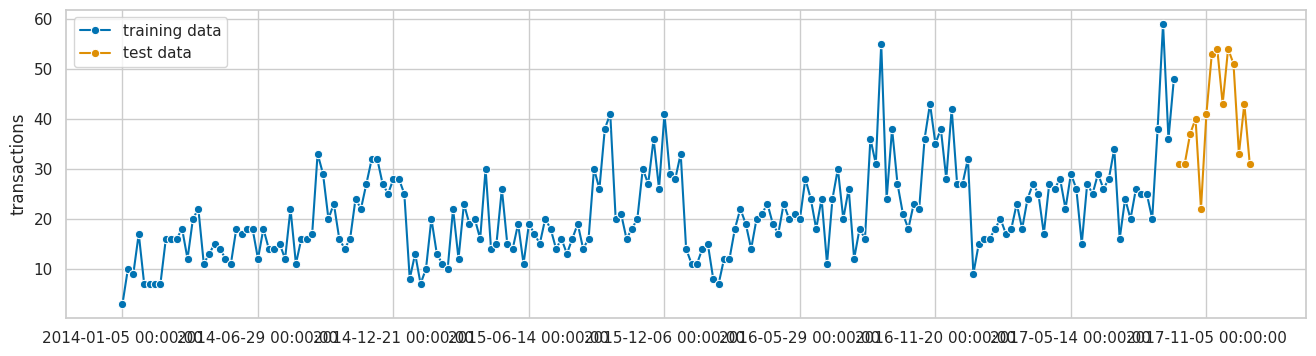

In [ ]:
# Split data
data_train = df_transaction.loc[df_visit.index <= '2017-9-30'] # dataset train, use a date before the test set start
data_test = df_transaction.loc[df_visit.index >= '2017-9-30'] # last 3 months for test, assigned to test_data correctly

# Pass the 'visits' column (which is a pandas Series) to plot_series
plot_series(data_train['transactions'], data_test['transactions'], labels=["training data", "test data"])

### Build SARIMA Model

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Menentukan parameter yang dipilih oleh auto_arima
order = (1,0,1)  # Non-musiman
seasonal_order = (2,0,0,52)  # Musiman tahunan dengan m=52

# Membangun model SARIMA menggunakan data latih
sarima_mod = SARIMAX(data_train['transactions'], order=order, seasonal_order=seasonal_order)

# Melatih model
sarima_mod_fit = sarima_mod.fit()

# Menampilkan ringkasan model
sarima_mod_fit.summary()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                        transactions   No. Observations:                  195
Model:             SARIMAX(1, 0, 1)x(2, 0, [], 52)   Log Likelihood                -649.216
Date:                             Fri, 23 May 2025   AIC                           1308.432
Time:                                     11:21:04   BIC                           1324.797
Sample:                                 01-05-2014   HQIC                          1315.058
                                      - 09-24-2017                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9954      0.006    174.577      0.000       0.984       1.007
ma.L1         -0.8500      0.047    -18.191      0.000      -0.942      -0.758
ar.S.L52       0.2665      0.050      5.373      0.000       0.169       0.364
ar.S.L104      0.4491      0.084      5.366      0.000       0.285       0.613
sigma2        37.0122      4.213      8.786      0.000      28.755      45.269
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):                14.83
Prob(Q):                              0.80   Prob(JB):                         0.00
Heteroskedasticity (H):               2.15   Skew:                             0.38
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

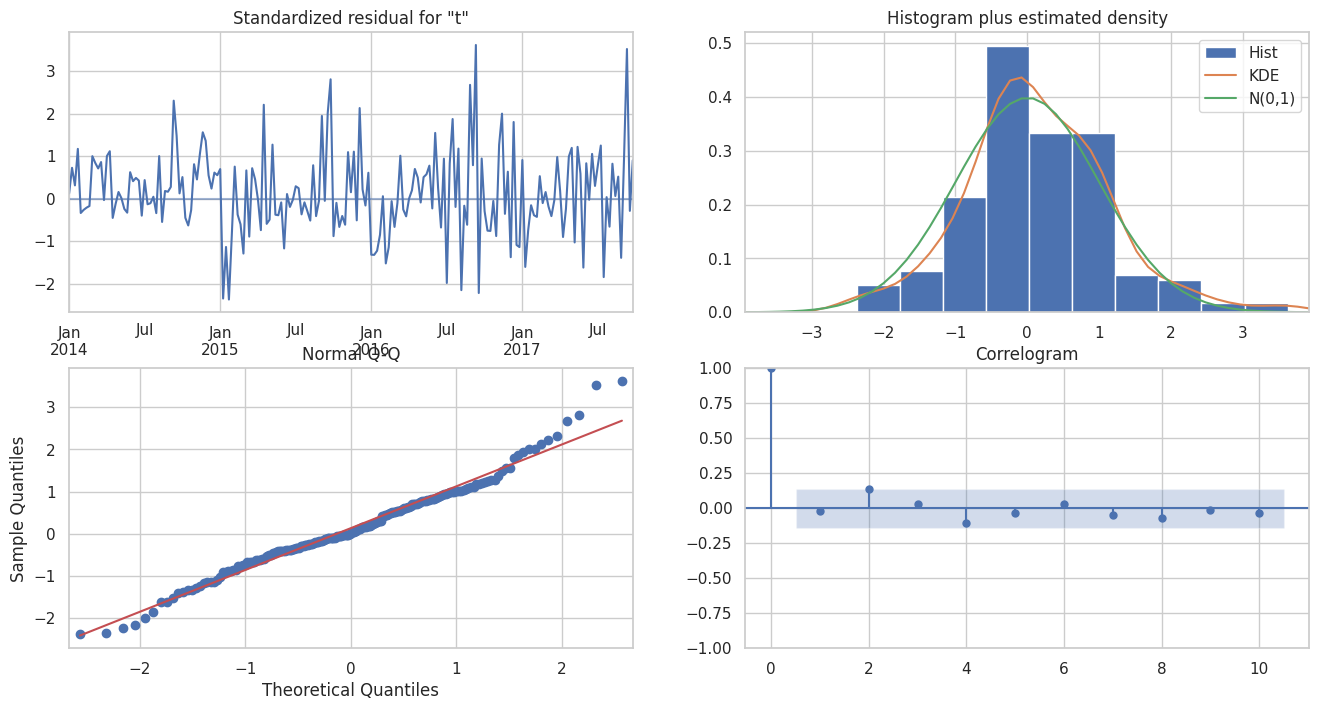

In [ ]:
sarima_mod_fit.plot_diagnostics(figsize=(16, 8))
plt.savefig('modeldiagnostics')
plt.show()

### Evaluation

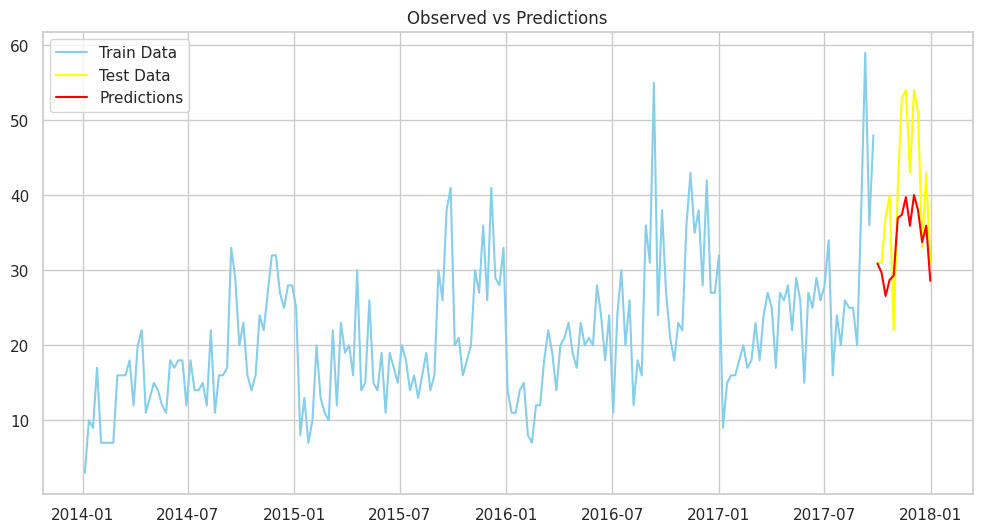

Mean Absolute Error (MAE): 7.675680540469687
Mean Absolute Percentage Error (MAPE): 17.97 %


In [ ]:
# Prediksi untuk rentang data test (dan bisa sampai akhir test data)
predic = sarima_mod_fit.get_prediction(start=data_test.index[0], end=data_test.index[-1])

# Dapatkan rata-rata prediksi dan confidence interval-nya
predic_mean = predic.predicted_mean
conf_int = predic.conf_int()

# Plot hasil prediksi dan data asli
plt.figure(figsize=(12, 6))
plt.plot(data_train.index, data_train['transactions'], label='Train Data', color='skyblue')
plt.plot(data_test.index, data_test['transactions'], label='Test Data', color='yellow')
plt.plot(pred_mean.index, pred_mean, label='Predictions', color='red')
plt.title('Observed vs Predictions')
plt.legend(loc='best')
plt.show()

# Hitung error prediksi (hanya pada test set)
mae_sarima = mean_absolute_error(data_test['transactions'], predic_mean)
mape_sarima = mean_absolute_percentage_error(data_test['transactions'], predic_mean)

print(f"Mean Absolute Error (MAE): {mae_sarima}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_sarima * 100:.2f} %")

## Model Time series : Prophet

In [ ]:
weekly_transaction = df_transaction.reset_index()

In [ ]:
# Rename columns to 'ds' and 'y' for Prophet
weekly_transaction = weekly_transaction.rename(columns={'date': 'ds', 'transactions': 'y'})
weekly_transaction.head()

,ds,y
0,2014-01-05,3
1,2014-01-12,10
2,2014-01-19,9
3,2014-01-26,17
4,2014-02-02,7


### Split Data

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='y'>)

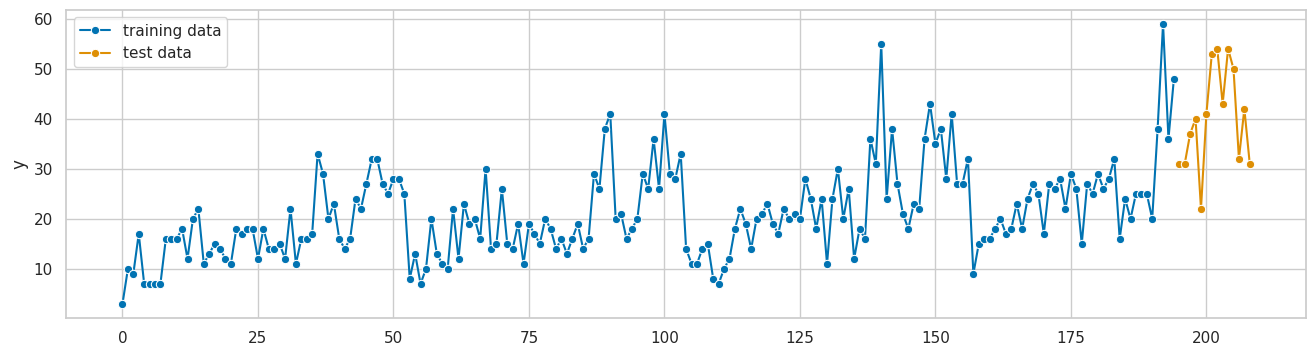

In [ ]:
# Split data
df_train = weekly_visit[weekly_transaction['ds'] <= '2017-9-30'] # dataset to train, use a date before the test set start
df_test = weekly_visit[weekly_transaction['ds'] >= '2017-9-30'] # last 3 months for test, assigned to test_data correctly

# Pass the 'visits' column (which is a pandas Series) to plot_series
# Make sure to pass the 'y' column (the visits data) for plotting
plot_series(df_train['y'], df_test['y'], labels=["training data", "test data"])

### Build Prophet model

In [ ]:
prophet_model = Prophet()
prophet_model.fit(df_train)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcr9od1r7/skdq_m_p.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcr9od1r7/zmvon9az.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44269', 'data', 'file=/tmp/tmpcr9od1r7/skdq_m_p.json', 'init=/tmp/tmpcr9od1r7/zmvon9az.json', 'output', 'file=/tmp/tmpcr9od1r7/prophet_modelqfkyzc_w/prophet_model-20250523112259.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:22:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:22:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
future = prophet_model.make_future_dataframe(periods=15, freq='W')

forecast = model_prophet.predict(future)

forecast[["ds","yhat","yhat_lower","yhat_upper"]].tail()

,ds,yhat,yhat_lower,yhat_upper
205,2017-12-10,38.334211,31.849513,44.957450
206,2017-12-17,37.804651,32.006426,43.917312
207,2017-12-24,34.640214,28.426045,41.088300
208,2017-12-31,28.661493,22.703151,34.477329
209,2018-01-07,22.453972,16.180702,28.540389


### Evaluation

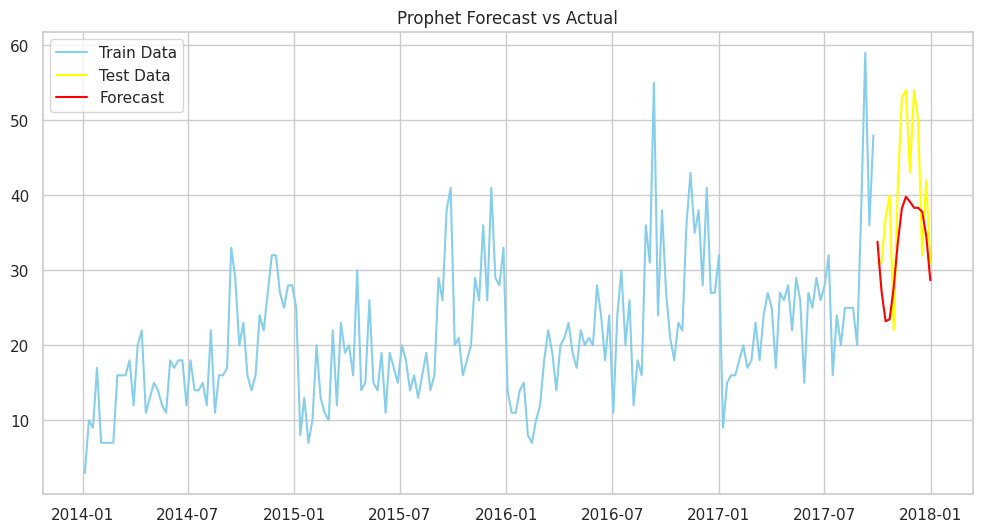

Mean Absolute Error (MAE): 8.974
Mean Absolute Percentage Error (MAPE): 21.61%


In [ ]:
forecast_test = forecast[forecast['ds'].isin(df_test['ds'])]

plt.figure(figsize=(12,6))
plt.plot(df_train['ds'], df_train['y'], label='Train Data', color='skyblue')
plt.plot(df_test['ds'], df_test['y'], label='Test Data', color='yellow')
plt.plot(forecast_test['ds'], forecast_test['yhat'], label='Forecast', color='red')
plt.legend()
plt.title('Prophet Forecast vs Actual')
plt.show()

#matriks evaluasi
merged = test_df.merge(forecast[['ds', 'yhat']], on='ds', how='inner')

mae = mean_absolute_error(merged['y'], merged['yhat'])
mape = mean_absolute_percentage_error(merged['y'], merged['yhat']) * 100

print(f"Mean Absolute Error (MAE): {mae:.3f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

## Predict for 1 month use the best model

berdasarkan hasil prediksi sebelumnya, model terbaik untuk menggambarkan jumlah transaksi yaitu model sarima (p=1, d=0, q=1) (P=2, D=0, Q=0, S=52). maka prediksi jumlah transaksi untuk 1 bulan kedepan yaitu

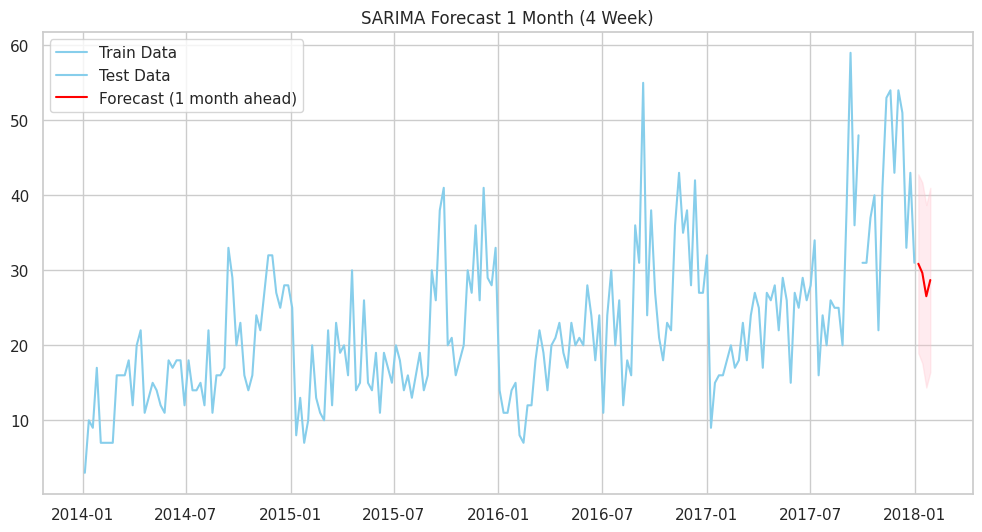

In [ ]:
import pandas as pd

# Mulai prediksi dari hari setelah data test terakhir
start_forecast = data_test.index[-1] + pd.Timedelta(weeks=1)

# Jumlah periode yang ingin diprediksi (4 minggu ke depan)
steps = 4

# Buat prediksi 4 minggu ke depan
forecast_obj = sarima_mod_fit.get_forecast(steps=steps)

# Ambil nilai prediksi rata-rata dan confidence interval
forecast_mean = forecast_obj.predicted_mean
forecast_conf_int = forecast_obj.conf_int()

# Buat index tanggal prediksi berdasarkan last date + step weeks
forecast_index = pd.date_range(start=start_forecast, periods=steps, freq='W')

# Update index prediksi dengan tanggal
forecast_mean.index = forecast_index
forecast_conf_int.index = forecast_index

# Visualisasi hasil prediksi 1 bulan kedepan
plt.figure(figsize=(12, 6))
plt.plot(data_train.index, data_train['transactions'], label='Train Data', color='skyblue')
plt.plot(data_test.index, data_test['transactions'], label='Test Data', color='skyblue')
plt.plot(forecast_mean.index, forecast_mean, label='Forecast (1 month ahead)', color='red')
plt.fill_between(forecast_conf_int.index,
                 forecast_conf_int.iloc[:, 0],
                 forecast_conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.title('SARIMA Forecast 1 Month (4 Week)')
plt.legend(loc='best')
plt.show()

In [ ]:
#nilai prediksi
forecast_mean.astype(int)

,predicted_mean
2018-01-07,30
2018-01-14,29
2018-01-21,26
2018-01-28,28


Model SARIMA ini memprediksi jumlah transaksi selama Januari 2018 berada di kisaran 25-30. Terlihat penurunan transaksi dari bulan sebelumnya (September-Desember), namun pola serupa di Januari tahun-tahun sebelumnya cenderung stabil atau sedikit meningkat. Hal ini wajar terjadi karena pengaruh musiman di akhir tahun. Sebagai rekomendasi bisnis, sebaiknya persiapkan strategi promosi atau peningkatan layanan pada awal tahun untuk memanfaatkan tren kenaikan transaksi setelah periode penurunan.

# Conclusion

1. Total Revenue dan Transaksi:
Total revenue 2017 mencapai 2,489,712 dengan 1,341 order dan 10,085 barang terjual. Rata-rata pembelian 7,52 unit per transaksi dan spending rata-rata 1,856,61 menunjukkan pelanggan cenderung beli dalam jumlah besar. <br>
Rekomendasi: Terapkan strategi bundling dan promosi pembelian dalam jumlah banyak untuk meningkatkan pendapatan.

2. Analisis Order dan GMV Berdasarkan Waktu:
Order harian fluktuatif dengan puncak di hari ke-20 dan 21, sedangkan order mingguan tertinggi di Senin dan Jumat, dan rendah di Rabu. Bulan September dan November menunjukkan lonjakan order dan GMV signifikan. <br>
Rekomendasi: Perkuat stok dan aktivitas pemasaran khusus di bulan dan hari puncak ini untuk memaksimalkan penjualan.

3. Produk Populer dan Bundling:
Produk Canon imageCLASS 2200 menjadi top revenue, didominasi kategori teknologi. Produk dari kategori Office Supplies dan Furniture juga diminati. Produk seperti meja adjustable & staples sering dibeli bersama. <br> Rekomendasi: Buat paket bundling produk populer dan produk yang sering dibeli bersama untuk meningkatkan nilai transaksi dan kemudahan pelanggan.

4. Distribusi Geografis Order dan Spending:
New York City dan Los Angeles memimpin order dan spending terbesar, sementara kota kecil seperti Jamestown punya rata-rata spending per order tertinggi.<br>
Rekomendasi: Kembangkan strategi pemasaran berbeda antara kota besar dengan volume tinggi dan kota kecil dengan nilai transaksi besar untuk optimalkan pendapatan.

5. Tren Musiman dan Forecasting:
Kunjungan rendah di awal tahun, naik mulai Maret, dan lonjakan signifikan di September-November, pola musiman yang konsisten. Model SARIMA menghasilkan mape terbaik untuk jumlah visit dan jumlah transaksi dengan hasil prediksi stabil untuk satu bulan ke depan. <br>
Rekomendasi: Gunakan hasil forecast untuk perencanaan stok dan aktivitas marketing, fokus pada bulan puncak agar layanan optimal dan potensi penjualan maksimal.